<a href="https://colab.research.google.com/github/deniseiras/Artificial-Intelligence/blob/main/CAP_351_Projeto_3_GNG_Denis_Eiras_e_Marcelo_Guatura_Experimento1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Projeto 3 - Rede GNG
### CAP-351 - Neurocomputação

Denis M. A. Eiras / Marcelo Guatura

24/08/2021

---
## Enunciado 

▸Selecionar pelo menos dois datasets:

▸Aplicar um modelo neural não supervisionado

▸Avaliar os padrões detectados em cada conjunto:

▸Clusters / outliers, etc.

▸Avaliar a homogeneidade dos agrupamentos

▸Variar os parâmetros do modelo (grid, taxas, número de neurônios, etc.)

---

## Instruções para executar

* Executar todo o Notebook

O Notebook acessa os dados via google drive, em um e-mail criado para este fim.

Utilizar o usuário e senha, quando solicitado pelo google drive:

usuário: neuralnetworks.data@gmail.com

senha: cap.351.neurocomputacao

Em seguida, copie o código gerado e cole no campo que é solicitado no Notebook

A execução leva em torno de 15 minutos


## Inicialização das bibliotecas e parâmetros gerais

In [ ]:
# Bibliotecas
!pip install neupy
import copy
from math import sqrt
import numpy as np
import pandas as pd
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from neupy import algorithms, utils
from google.colab import drive
from IPython import display
import json

import time
import warnings               # To suppress warnings
# import plotly.plotly as py   #For World Map
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
import os                    
import sys       
import itertools            

# Parâmetros gerais
RANDOM_STATE = 987
np.random.seed(RANDOM_STATE)
utils.reproducible(RANDOM_STATE)

# Acesso ao google drive
drive.mount('/content/drive', force_remount=True)
colab_in_drive_root_dir = "/content/drive/My Drive/Colab Notebooks/"
data_in_drive_dir = "/content/drive/My Drive/proj3/"

Mounted at /content/drive


## Funções gerais

In [ ]:
# Constantes padrão de estilo para a função de visualização dos modelos GNG
DEFAULT_SCATTER_KWARGS = {'color': 'k', 'zorder': 1000, 's': 5}
DEFAULT_PLOT_KWARGS = {'linewidth': 1, 'color': 'k', 'zorder': 500}


def graph_edge(node_1, node_2, dimensions: tuple, **kwargs):
    """Função para plotar a ligação de dois nós em um grafo.
    Args:
        node_1 (neupy.NeuronNode): Primeiro neurônio envolvido na ligação
        node_2 (neupy.NeuronNode): Segundo neurônio envolvido na ligação
        dimensions (tuple): Dimensões consideradas no plot (Posição da feature)
        kwargs (dict): Argumentos extras para a função matplotlib.pyplot.plot
    Returns:
        matplotlib.pyplot.Axes: Instância criada para representar o nó na figura
    See:
        https://github.com/itdxer/neupy/blob/master/notebooks/growing-neural-gas/Growing%20Neural%20Gas%20-%20step%20by%20step%20visualizations.ipynb
    """
    
    weights = np.concatenate([node_1.weight[:, dimensions], 
                              node_2.weight[:, dimensions]])
    return plt.plot(*weights.T, **kwargs)


def graph(graph, dimensions, scatter_kwargs = None, plot_kwargs = None):
    """Função para gerar a visualização de um grafo não direcionado. A função
    foi criada para representar a estrutura interna do NeuPy para representar os nós da rede GNG
    
    Args:
        graph (neupy.NeuralGasGraph): Grafo não direcionado com as relações de cada neurônio 
        dimensions (tuple): Dimensões consideradas no plot (Nome da feature)
        scatter_kwargs (dict): Argumentos extras para a função matplotlib.pyplot.scatter 
          utilizada para representar cada neurônio
        plot_kwargs (dict): Argumentos extras para a função matplotlib.pyplot.plot utilizada para cada conexão
    Returns:
        None
    See:
        https://github.com/itdxer/neupy/blob/master/notebooks/growing-neural-gas/Growing%20Neural%20Gas%20-%20step%20by%20step%20visualizations.ipynb
    """

    if not plot_kwargs:
        plot_kwargs = {'color': 'black', 'alpha': 1, 'zorder': 500}
    if not scatter_kwargs:
        scatter_kwargs = {'color': 'red', 'zorder': 1000, 's': 160}
        
    if 'zorder' not in scatter_kwargs:
        scatter_kwargs['zorder'] = 1000
    if 'zorder' not in plot_kwargs:
        plot_kwargs['zorder'] = 500
    
    for node_1, node_2 in graph.edges:
        graph_edge(node_1, node_2, dimensions, **plot_kwargs)
        
    weights = np.concatenate([node.weight[:, dimensions] for node in graph.nodes])
    plt.scatter(*weights.T, **scatter_kwargs)

    
def get_2d_position(feature_names, list_of_all_feature_names_avaliable):
    """Função criada para recuperar de maneira facilitada a dimensão que está sendo
    tratada para a visualização da GNG. Esta função foi feita para tornar possível a consideração
    de que, as operações realizadas pela rede consideram múltiplas dimensões
    
    Args:
        feature_names (tuple): Tupla com as duas dimensões que estão sendo consideradas na visualização
        list_of_all_feature_names_avaliable (list): Lista com todos os nomes de features presentes no conjunto
        de dados
    Returns:
        tuple: Tupla com a posição das dimensões
    """
    return list((list_of_all_feature_names_avaliable.index(feature_name) for feature_name in feature_names))


def show_gng_models(gng_models, 
                          gng_models_labels, 
                          dimensions,
                          background_spec,
                          grid_spec, 
                          title_size = 12,
                          is_grouped_by=True,
                          scatter_labels=False,
                          legend_every=2,
                          plot_kwargs = DEFAULT_PLOT_KWARGS,
                          scatter_kwargs = DEFAULT_SCATTER_KWARGS,
                    ):
    """Função para facilitar a visualização com múltiplos plots de modelos GNG
    Args:
        gng_models (list): Lista com os modelos GNG treinados
        gng_models_labels (list): Lista de strings com o título de cada modelo
        dimensions (tuple): Posição dos atributos utilizados na visualização
        background_spec (dict): Dicionário com as chaves ['data', 'x', 'y', 'label']. Utilizado
        para criar um plano de fundo ao plot de modelo gerado
        grid_spec (tuple): Especificação do grid onde os subplots serão realizados
        title_size (int): Tamanho da fonte do título
        scatter_kwargs (dict): Argumentos extras para a função matplotlib.pyplot.scatter 
        utilizada para representar cada neurônio
        plot_kwargs (dict): Argumentos extras para a função matplotlib.pyplot.plot utilizada para cada conexão
    Returns:
        None
    """

    fig = plt.figure(figsize = (14, 32), dpi = 100)
    idx = 1 
    if legend_every == 2:
      legend_right_space = 1.35
    else:
      legend_right_space = 1.20

    for i in range(1, len(gng_models) + 1):
        ax = plt.subplot(grid_spec[0], grid_spec[1], idx)
        # ax.figure.tight_layout()

        if not is_grouped_by:
          x_data=background_spec['data'][background_spec['x']]
          y_data=background_spec['data'][background_spec['y']]
          plt.scatter(x_data, y_data, alpha = 0.4)
          plt.xlabel(background_spec['x'])
          plt.ylabel(background_spec['y'])
        else:
          group_col_id = background_spec['label_scatter_id']
          group_col = background_spec['label_scatter']
          plt_data = background_spec['data']
          # reversed color map
          group_ids=np.unique(plt_data[[group_col_id]])
          group_ids=np.flip(group_ids)
          markers = ["o","v","^","<",">","8","s","P","*","X","D"]
          colors = MinMaxScaler().fit_transform(group_ids.reshape(-1, 1))

          last_label=""
          for index, each_data in plt_data.iterrows():
            x_data=each_data[background_spec['x']]
            y_data=each_data[background_spec['y']]
            grp_id=int(each_data[group_col_id])
            color = background_spec['cmap'](colors[grp_id-1])
            # marker=markers[each_data[grp_id]%len(markers)]
            marker=markers[grp_id%len(markers)]
            label=each_data[group_col]
            if label != last_label:
              last_label = label
              plt.scatter(x_data, y_data, alpha = 0.4,
                marker=marker,
                color=color,
                label=label
              )
            else:
              plt.scatter(x_data, y_data, alpha = 0.4,
                marker=marker,
                color=color
              )
            plt.xlabel(background_spec['x'])
            plt.ylabel(background_spec['y'])
            if i%legend_every == 0:
              plt.legend(loc='upper right', prop={'size': 6}, bbox_to_anchor=(legend_right_space, 1))


        graph(gng_models[idx - 1].graph, dimensions, 
              scatter_kwargs = scatter_kwargs,
              plot_kwargs = plot_kwargs)
        
        if scatter_labels:
          labels_of_scatter=(background_spec['data'])[background_spec['label_scatter']]
          x_pos=background_spec['data'][[background_spec['x']]]
          y_pos=background_spec['data'][[background_spec['y']]]

          for i, txt in enumerate(labels_of_scatter):
            x=x_pos.iloc[i]
            y=y_pos.iloc[i]
            ax.annotate(txt, (x, y), fontsize=6, rotation=45)
            
        plt.title(gng_models_labels[idx - 1], fontdict = {'fontsize': title_size}); idx += 1
    
    plt.subplots_adjust(hspace=0.3, wspace= 0.2)
    plt.show()
    

def generate_title_names(name_pattern, values, **kwargs):
    """Função auxiliar para gerar títulos de subfiguras utilizando 
    o nome da propriedade e o valor
    
    Args:
        name_pattern (str): Nome da propriedade que deve ser vinculada aos valores (string pattern com propriedade `value` disponível). e. g. test = {value}
        
        values (list): Lista de valores
    Returns:
        list: Lista de string que vincula a propriedade com o valor aplicado
    """
    return [name_pattern.format(value = value, **kwargs) for value in values]


## Experimento 1 - Classificação de estilos de cerveja (BJCP)

### Funções e parâmetros do experimento

In [ ]:

def show_all_gng_models(gng_models,str_fmt_titles, arr_titles):

  title_names = generate_title_names(str_fmt_titles, arr_titles)

  for dims_cols in [['abv', 'ibu'], ['abv', 'srm'], ['ibu', 'srm']]:

    dims = get_2d_position(dims_cols, feature_names)
    show_gng_models(gng_models, title_names, dims, 
      {
        'data': styles_mean,
        'x': dims_cols[0],
        'y': dims_cols[1],
        'label_scatter': grouped_by,
        'label_scatter_id': grouped_by_id,
        'cmap': color_map
      }, (5, 2)
      , scatter_labels=False)
  

# Parâmetros para plotagem do 
grouped_by = 'parent.name'
grouped_by_id = 'parent.id'
feature_names=['abv', 'ibu', 'srm']
cmap = 'hsv'
color_map = plt.cm.get_cmap(cmap).reversed()

### BJCP data set

In [ ]:
style_data = json.load(open('{}/styleguide-2015.json'.format(data_in_drive_dir)))
categories = style_data['styleguide']['class'][0]['category']

# drill down into subcategories and append the parent category as a field on each subcategory
all_categories = []
for category in categories:
    for sub_category in category['subcategory']:
        sub_category['parent'] = category
        all_categories.append(sub_category)
        
styles = pd.json_normalize(all_categories)
# styles.to_csv('{}/styleguide-2015.csv'.format(data_in_drive_dir))


### Pré-processamento
Seleção das variáveis ABV (Alcoohol by volume). e IBU (Internationall Bitterness Unit) e SRM (código de cor) como sendo a média de seus máximos e mínimos, que serão utilizadas no algoritmo GNG

As variáveis são normalizadas para um melhor agrupamento do algoritmo GNG

In [ ]:
num_cols=['stats.abv.high', 'stats.abv.low', 'stats.ibu.high', 'stats.ibu.low', 'stats.srm.high', 'stats.srm.low']
cols = num_cols + ['id', 'name', 'parent.name', 'parent.id'] 
styles_tmp = pd.DataFrame(styles, columns=cols)
styles_tmp.dropna(inplace=True)

for col in num_cols:
  styles_tmp[col] = pd.to_numeric(styles_tmp[col], downcast="float")
styles_tmp['parent.id'] = pd.to_numeric(styles_tmp['parent.id'], downcast="integer")

styles_mean = pd.DataFrame()
styles_mean['abv_mean'] = (styles_tmp['stats.abv.high'] + styles_tmp['stats.abv.low'])/2
styles_mean['ibu_mean'] = (styles_tmp['stats.ibu.high'] + styles_tmp['stats.ibu.low'])/2
styles_mean['srm_mean'] = (styles_tmp['stats.srm.high'] + styles_tmp['stats.srm.low'])/2
styles_mean['id'] = styles_tmp['id']
styles_mean['name'] = styles_tmp['name']
styles_mean['parent.name'] = styles_tmp['parent.name']
styles_mean['parent.id'] = styles_tmp['parent.id']

scaler = MinMaxScaler()
styles_mean[['abv', 'ibu', 'srm']] = scaler.fit_transform(styles_mean[['abv_mean', 'ibu_mean', 'srm_mean']])
styles_mean.sort_values(['parent.id'], ascending=True, inplace=True)


### Análise dos dados

Alguns valores e estatísticas

In [ ]:
pd.set_option('display.max_rows', None)
print("Estatísticas")
display.display(styles_mean.describe())
print('Todos estilos, ordenados por  parent name, name')
display.display(styles_mean.sort_values(['parent.name', 'name'], ascending=True))
print('Valores médios de parent beers, agrupados e ordenados por parent.name')
display.display(styles_mean.groupby('parent.name').mean().sort_values(['parent.name'], ascending=True), )

Estatísticas


abv_mean   ibu_mean   srm_mean  ...         abv         ibu         srm
count  100.000000  100.00000  100.00000  ...  100.000000  100.000000  100.000000
mean     5.835000   30.52500   13.75000  ...    0.345087    0.300294    0.346154
std      1.771413   17.10298    9.15095  ...    0.204788    0.201212    0.281568
min      2.850000    5.00000    2.50000  ...    0.000000    0.000000    0.000000
25%      4.875000   21.37500    5.00000  ...    0.234104    0.192647    0.076923
50%      5.275000   26.25000   12.50000  ...    0.280347    0.250000    0.307692
75%      6.750000   37.50000   18.00000  ...    0.450867    0.382353    0.476923
max     11.500000   90.00000   35.00000  ...    1.000000    1.000000    1.000000

[8 rows x 7 columns]

Todos estilos, ordenados por  parent name, name


abv_mean  ibu_mean  srm_mean  ...       abv       ibu       srm
22       4.90      37.5     14.00  ...  0.236994  0.382353  0.353846
25       5.10      32.5     12.00  ...  0.260116  0.323529  0.292308
24       5.05      32.5      5.00  ...  0.254335  0.323529  0.076923
21       5.10      24.0     12.00  ...  0.260116  0.223529  0.292308
20       6.75      23.5     18.00  ...  0.450867  0.217647  0.476923
18       6.05      21.0     12.50  ...  0.369942  0.188235  0.307692
19       5.40      25.0     17.00  ...  0.294798  0.235294  0.446154
59       5.35      32.5     13.50  ...  0.289017  0.323529  0.338462
61       5.25      25.0     26.50  ...  0.277457  0.235294  0.738462
60       5.00      37.5     12.00  ...  0.248555  0.382353  0.292308
62       5.65      37.5     31.00  ...  0.323699  0.382353  0.876923
63       6.00      55.0     35.00  ...  0.364162  0.588235  1.000000
64      10.00      70.0     35.00  ...  0.826590  0.764706  1.000000
84       5.15      25.0     11.00  ...  0.265896  0.235294  0.261538
85       7.25      23.0     12.50  ...  0.508671  0.211765  0.307692
83       5.00      14.0      3.00  ...  0.248555  0.105882  0.015385
35       4.20      32.5     12.00  ...  0.156069  0.323529  0.292308
34       3.50      30.0     11.00  ...  0.075144  0.294118  0.261538
36       5.40      40.0     13.00  ...  0.294798  0.411765  0.323077
41       4.80      25.0     17.00  ...  0.225434  0.235294  0.446154
40       3.40      17.5     18.50  ...  0.063584  0.147059  0.492308
42       4.70      26.5     25.00  ...  0.213873  0.252941  0.692308
9        5.10      27.5     13.00  ...  0.260116  0.264706  0.323077
10       5.10      26.0     24.50  ...  0.260116  0.247059  0.676923
7        3.55      27.5      4.50  ...  0.080925  0.264706  0.061538
8        5.00      37.5      4.75  ...  0.248555  0.382353  0.069231
52       7.15      60.0     35.00  ...  0.497110  0.647059  1.000000
50       5.05      32.5     31.00  ...  0.254335  0.323529  0.876923
49       5.00      30.0     35.00  ...  0.248555  0.294118  1.000000
51       6.75      40.0     35.00  ...  0.450867  0.411765  1.000000
26       5.05      23.0     21.00  ...  0.254335  0.211765  0.569231
27       4.90      25.0     23.50  ...  0.236994  0.235294  0.646154
77       3.30       5.5      2.50  ...  0.052023  0.005882  0.000000
78       5.55      17.5     13.00  ...  0.312139  0.147059  0.323077
82       6.00       5.0      5.00  ...  0.364162  0.000000  0.076923
81       6.50       5.0      5.00  ...  0.421965  0.000000  0.076923
80       5.75       5.0      5.00  ...  0.335260  0.000000  0.076923
79       6.00      22.5     18.50  ...  0.364162  0.205882  0.492308
32       4.95      14.0     18.50  ...  0.242775  0.105882  0.492308
31       4.95      11.5      4.00  ...  0.242775  0.076471  0.046154
33       7.75      22.5     15.50  ...  0.566474  0.205882  0.400000
93       4.50       8.5      3.50  ...  0.190751  0.041176  0.030769
94       4.75      22.5     15.50  ...  0.219653  0.205882  0.400000
95       4.10       8.5      4.50  ...  0.144509  0.041176  0.061538
96       3.20      17.5     28.50  ...  0.040462  0.147059  0.800000
97       2.90      27.5      4.50  ...  0.005780  0.264706  0.061538
98       5.25      32.5      4.50  ...  0.277457  0.323529  0.061538
99       5.25      25.0     24.00  ...  0.277457  0.235294  0.661538
100      5.25      15.0     16.50  ...  0.277457  0.117647  0.430769
101      9.00      11.0     13.00  ...  0.710983  0.070588  0.323077
65       6.50      55.0     10.00  ...  0.421965  0.588235  0.230769
67       7.85      75.0     10.00  ...  0.578035  0.823529  0.230769
68       7.25      70.0     32.50  ...  0.508671  0.764706  0.923077
69       6.50      55.0     15.00  ...  0.421965  0.588235  0.384615
70       6.50      55.0     15.00  ...  0.421965  0.588235  0.384615
71       6.75      62.5     10.00  ...  0.450867  0.676471  0.230769
72       6.25      55.0      6.50  ...  0.393064  0.588235  0.123077
5  

Valores médios de parent beers, agrupados e ordenados por parent.name


abv_mean   ibu_mean  ...       ibu       srm
parent.name                                         ...                    
Amber Bitter European Beer     5.037500  31.625000  ...  0.313235  0.253846
Amber Malty European Lager     6.066667  23.166666  ...  0.213726  0.410256
Amber and Brown American Beer  5.200000  31.666666  ...  0.313726  0.456410
American Porter and Stout      7.216667  54.166668  ...  0.578431  0.958974
Belgian Ale                    5.800000  20.666666  ...  0.184314  0.194872
British Bitter                 4.366666  34.166668  ...  0.343137  0.292308
Brown British Beer             4.300000  23.000000  ...  0.211765  0.543590
Czech Lager                    4.687500  29.625000  ...  0.289706  0.282692
Dark British Beer              5.987500  40.625000  ...  0.419118  0.969231
Dark European Lager            4.975000  24.000000  ...  0.223529  0.607692
European Sour Ale              5.516667  10.083333  ...  0.059804  0.174359
German Wheat Beer              5.883333  16.000000  ...  0.129412  0.312821
Historical Beer                4.911111  18.666666  ...  0.160784  0.314530
IPA                            6.800000  61.071430  ...  0.659664  0.358242
International Lager            5.233334  17.333334  ...  0.145098  0.256410
Irish Beer                     4.883333  33.500000  ...  0.335294  0.707692
Pale American Ale              5.000000  30.750000  ...  0.302941  0.107692
Pale Bitter European Beer      4.500000  25.375000  ...  0.239706  0.051923
Pale Commonwealth Beer         5.300000  36.666668  ...  0.372549  0.123077
Pale Malty European Lager      5.983334  23.166666  ...  0.213726  0.107692
Scottish Ale                   3.783333  17.500000  ...  0.147059  0.482051
Standard American Beer         4.475000  14.875000  ...  0.116176  0.028846
Strong American Ale            9.225000  71.250000  ...  0.779412  0.300000
Strong Belgian Ale             6.666667  26.166666  ...  0.249020  0.123077
Strong British Ale             8.062500  42.125000  ...  0.436765  0.426923
Strong European Beer           9.333333  27.000000  ...  0.258824  0.569231
Trappist Ale                   7.675000  28.125000  ...  0.272059  0.232692

[27 rows x 7 columns]

Distribuição dos estilos

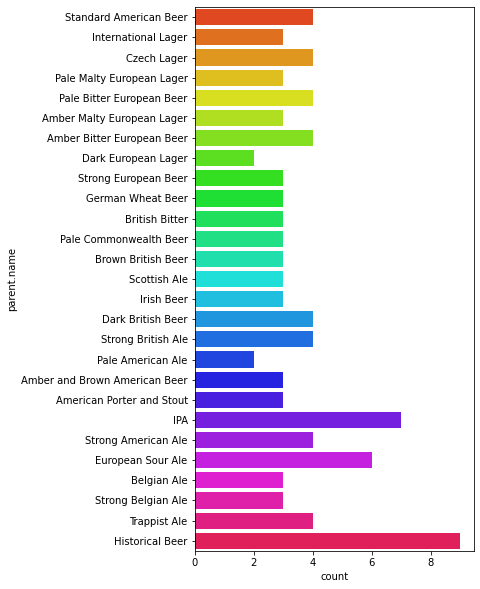

In [ ]:
# Distribuição dos estilos, ordenada por parent id
ax= sns.countplot(y='parent.name', data=styles_mean, palette=cmap)
ax.figure.set_size_inches(5,10)

Distribuiçãos dos estilos por médias de ABV, IBU e SRM

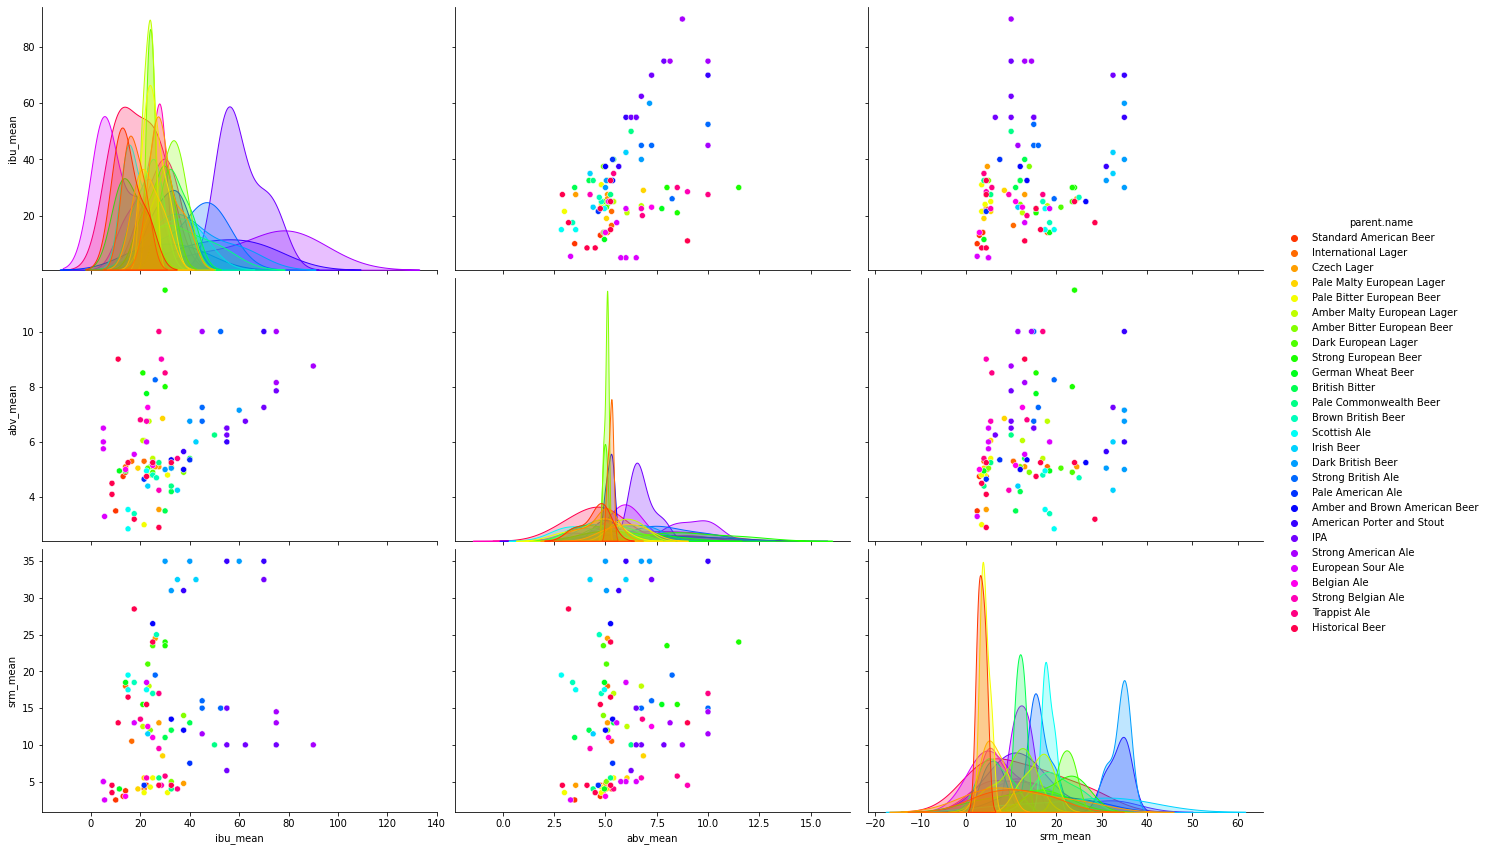

In [ ]:
grouped_by='parent.name'
ax = sns.pairplot(styles_mean[['ibu_mean', 'abv_mean', 'srm_mean', grouped_by]], height=4, hue = grouped_by, palette=cmap, aspect=1.5)
# sns.pairplot(styles_mean[['abv_mean', 'ibu_mean', grouped_by]], height=6, hue = grouped_by, palette=cmap)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

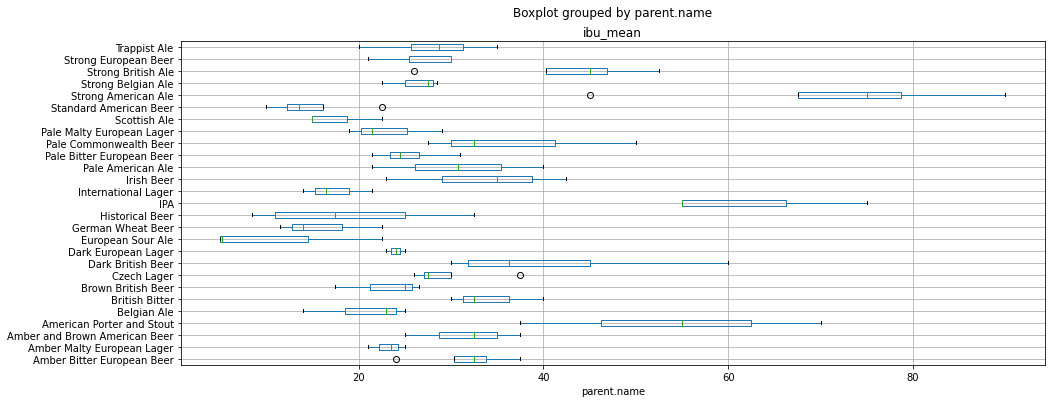

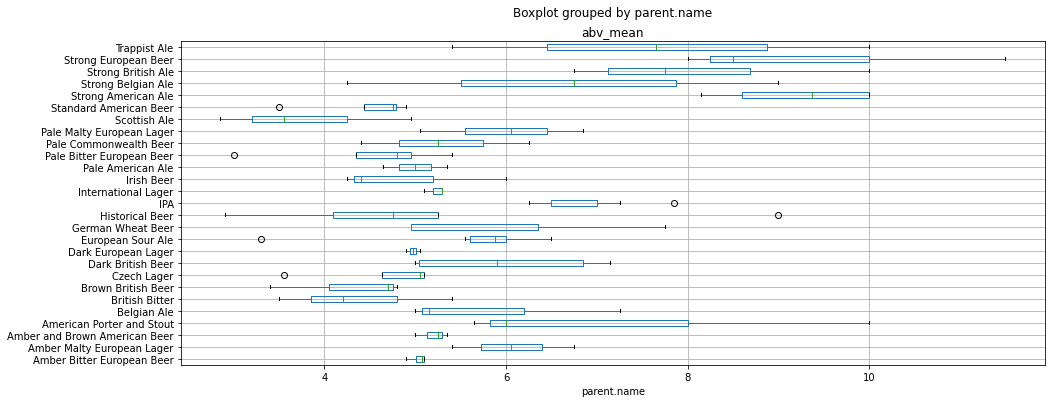

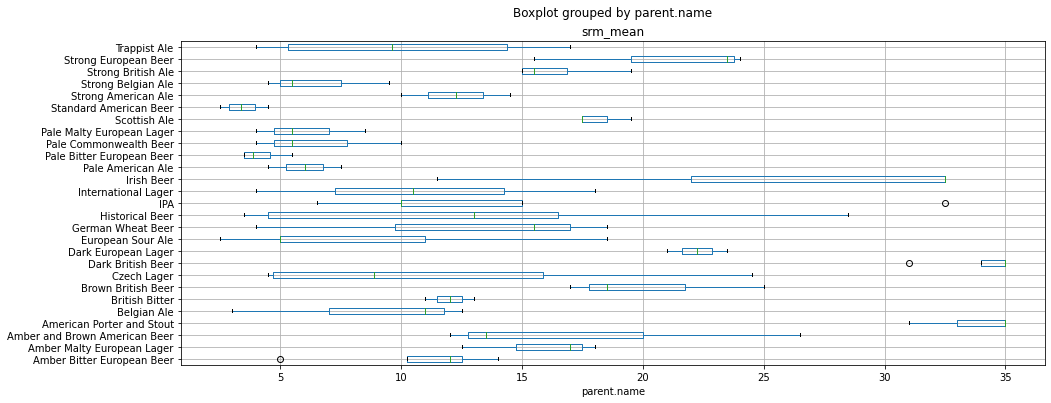

In [ ]:
for key in ['ibu_mean', 'abv_mean', 'srm_mean']:
  styles_mean.boxplot(column=key, by=grouped_by, figsize=(15, 6), vert=False)

### Variações de parâmetros
Serão feitos testes variando os seguintes parâmetros individualmente:

**Teste 1**) Variar o número de épocas.

**Teste 2**) Variar a idade máxima das arestas.

**Teste 3**) Variar o tempo máximo antes de um neurônio ser adicionado.

**Teste 4**) Variar a distância mínima para atualização.

Os gráficos apresentam os agrupamentos por ibu x abv, ibu x srm e abv x srm.

Informações da classe GNG:

Parâmetros variados:

    max_nodes : int
        Maximum number of nodes that would be generated during the training.
        This parameter won't stop training when maximum number of nodes
        will be exceeded. Defaults to ``1000``.
    max_edge_age : int
        It means that if edge won't be updated for ``max_edge_age`` iterations
        than it would be removed. The larger the value the more updates we
        allow to do before removing edge. Defaults to ``100``.
    n_iter_before_neuron_added : int
        Each ``n_iter_before_neuron_added`` weight update algorithm add new
        neuron. The smaller the value the more frequently algorithm adds
        new neurons to the network. Defaults to ``1000``.
    min_distance_for_update : float
        Parameter controls for which neurons we want to apply updates.
        In case if euclidean distance between data sample and closest
        neurons will be less than the ``min_distance_for_update`` value than
        update would be skipped for this data sample. Setting value to zero
        will disable effect provided by this parameter. Defaults to ``0``.

Parâmetros não variados:

    step : float
        Step (learning rate) for the neuron winner. Defaults to ``0.2``.
    neighbour_step : float
        Step (learning rate) for the neurons that connected via edges
        with neuron winner. This value typically has to be smaller than
        ``step`` value. Defaults to ``0.05``.
    error_decay_rate : float
        This error decay rate would be applied to every neuron in the
        graph after each training iteration. It ensures that old errors
        will be reduced over time. Defaults to ``0.995``.
    after_split_error_decay_rate : float
        This decay rate reduces error for neurons with largest errors
        after algorithm added new neuron. This value typically lower than
        ``error_decay_rate``. Defaults to ``0.5``.




#### Teste 1. Variar o número de épocas e identificar o número máximo de nós e arestas possíveis.
À partir de um número de superestilos máximo = 100 (total de estilos), variar o número de épocas para identificar os melhores agrupamentos.

Numero máximo de estilos = 100.


52 nós e 51 arestas gerados em 500 épocas


72 nós e 61 arestas gerados em 700 épocas


82 nós e 65 arestas gerados em 800 épocas


92 nós e 69 arestas gerados em 900 épocas


100 nós e 69 arestas gerados em 1000 épocas


100 nós e 65 arestas gerados em 1100 épocas


100 nós e 65 arestas gerados em 1200 épocas


100 nós e 65 arestas gerados em 1300 épocas


100 nós e 65 arestas gerados em 1500 épocas


100 nós e 65 arestas gerados em 2000 épocas


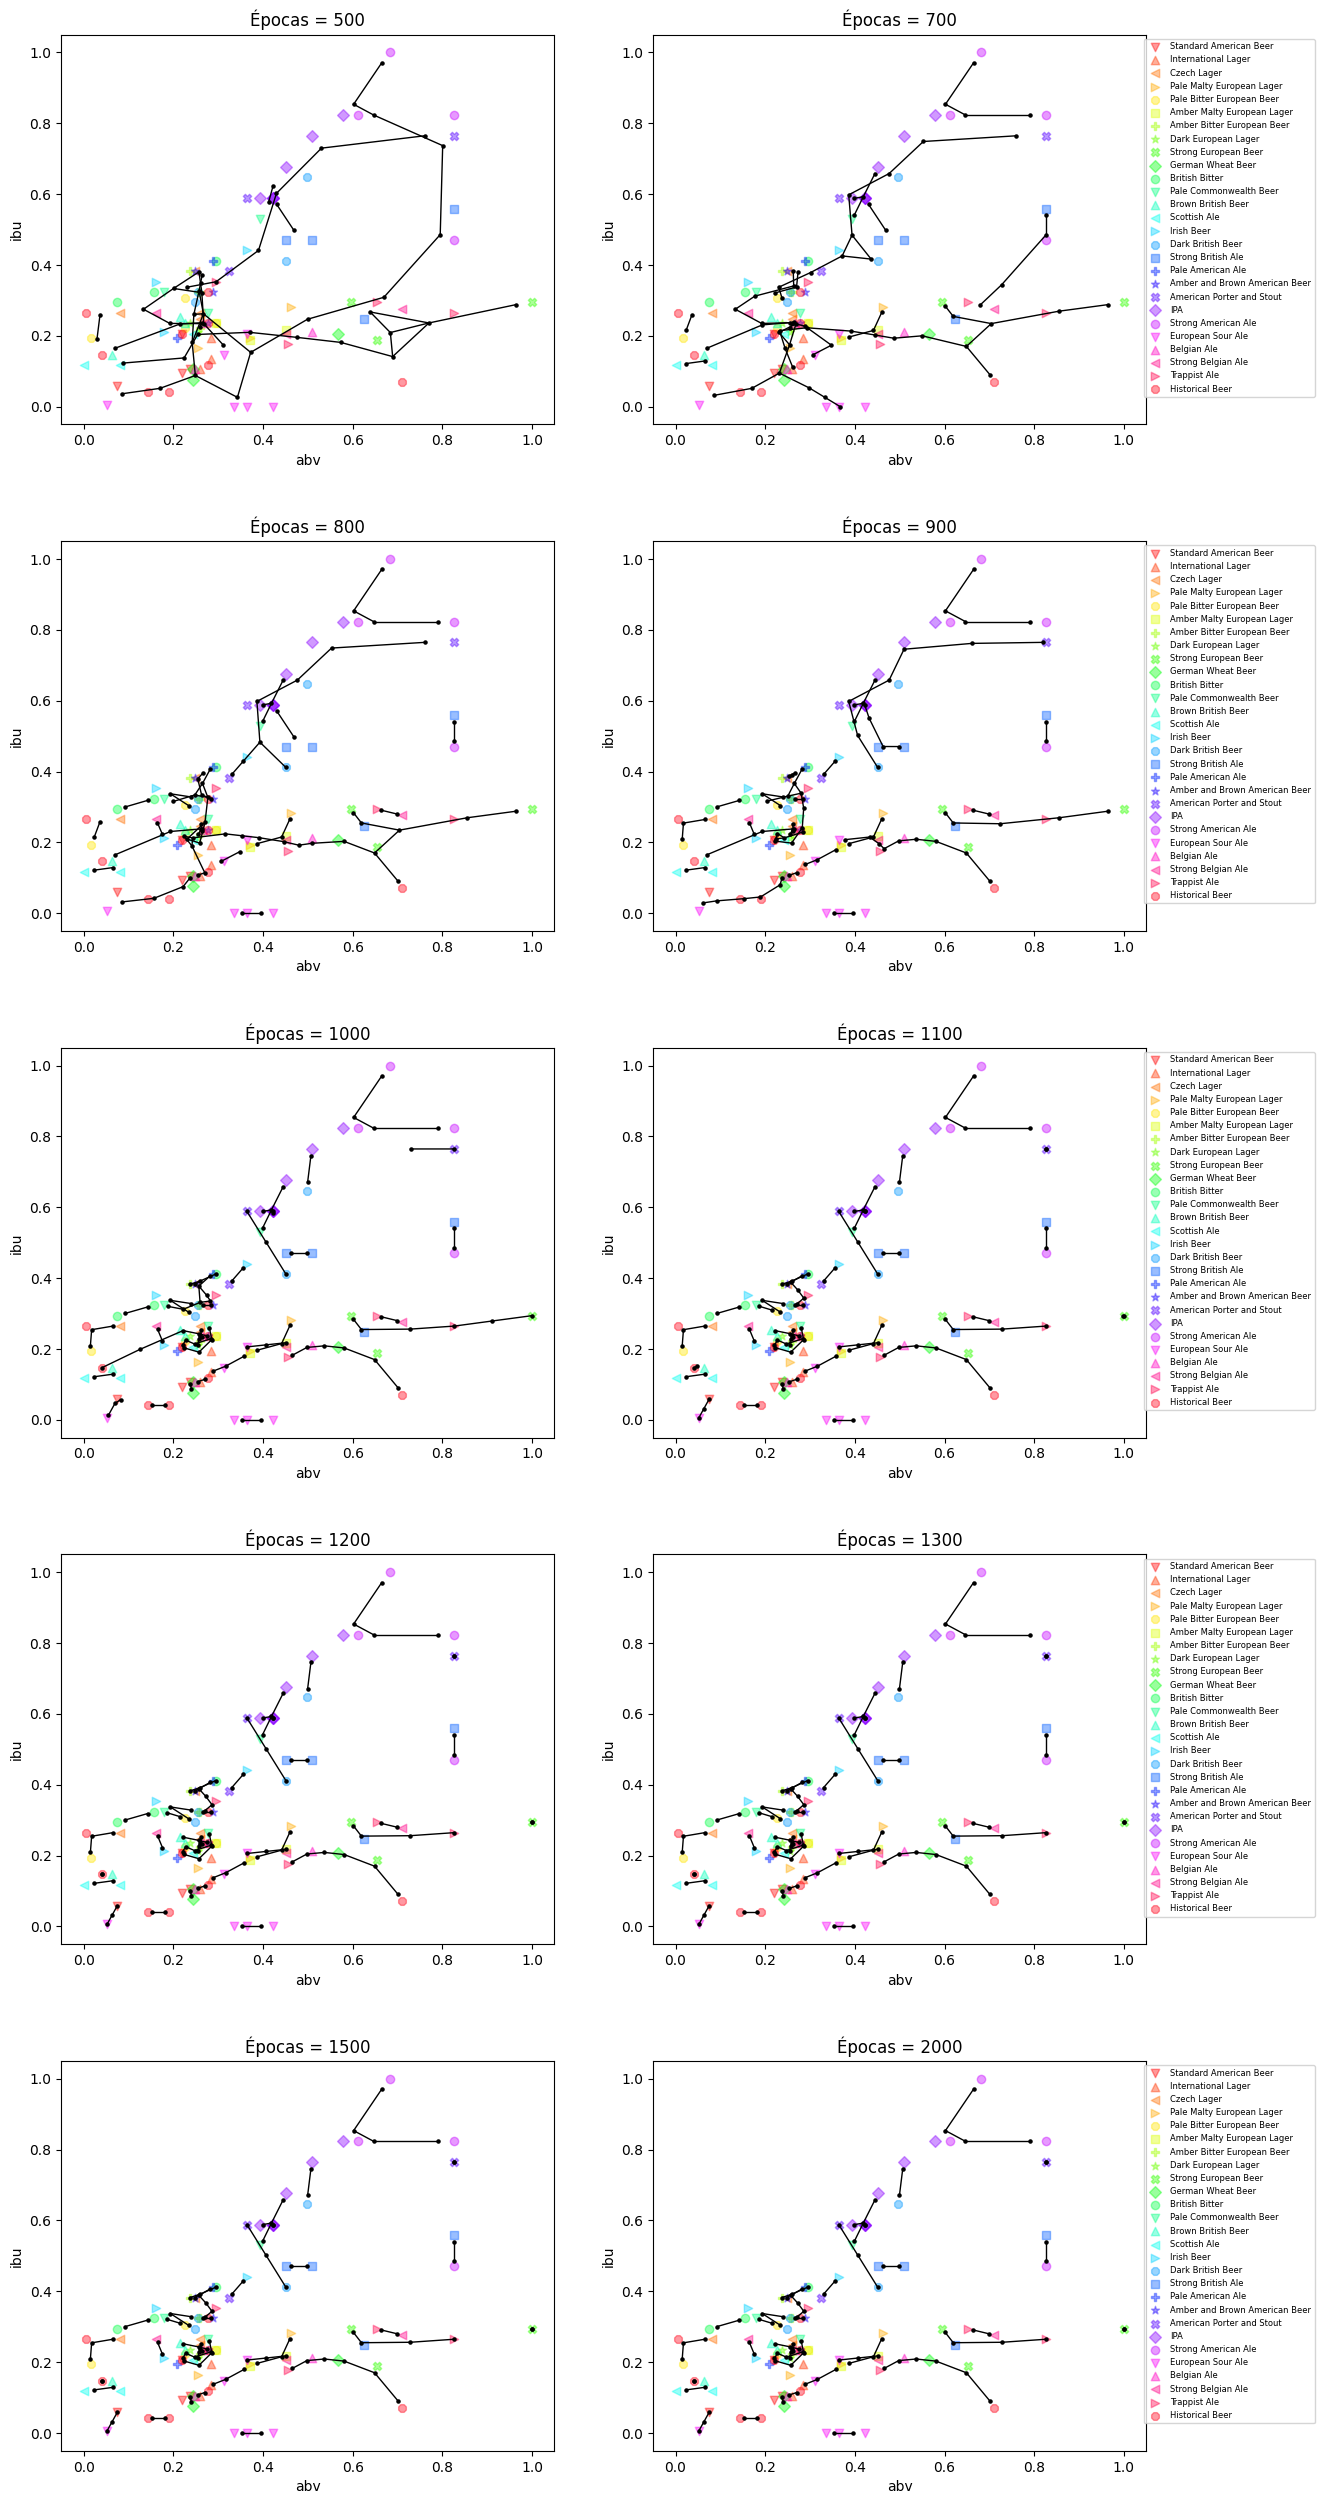

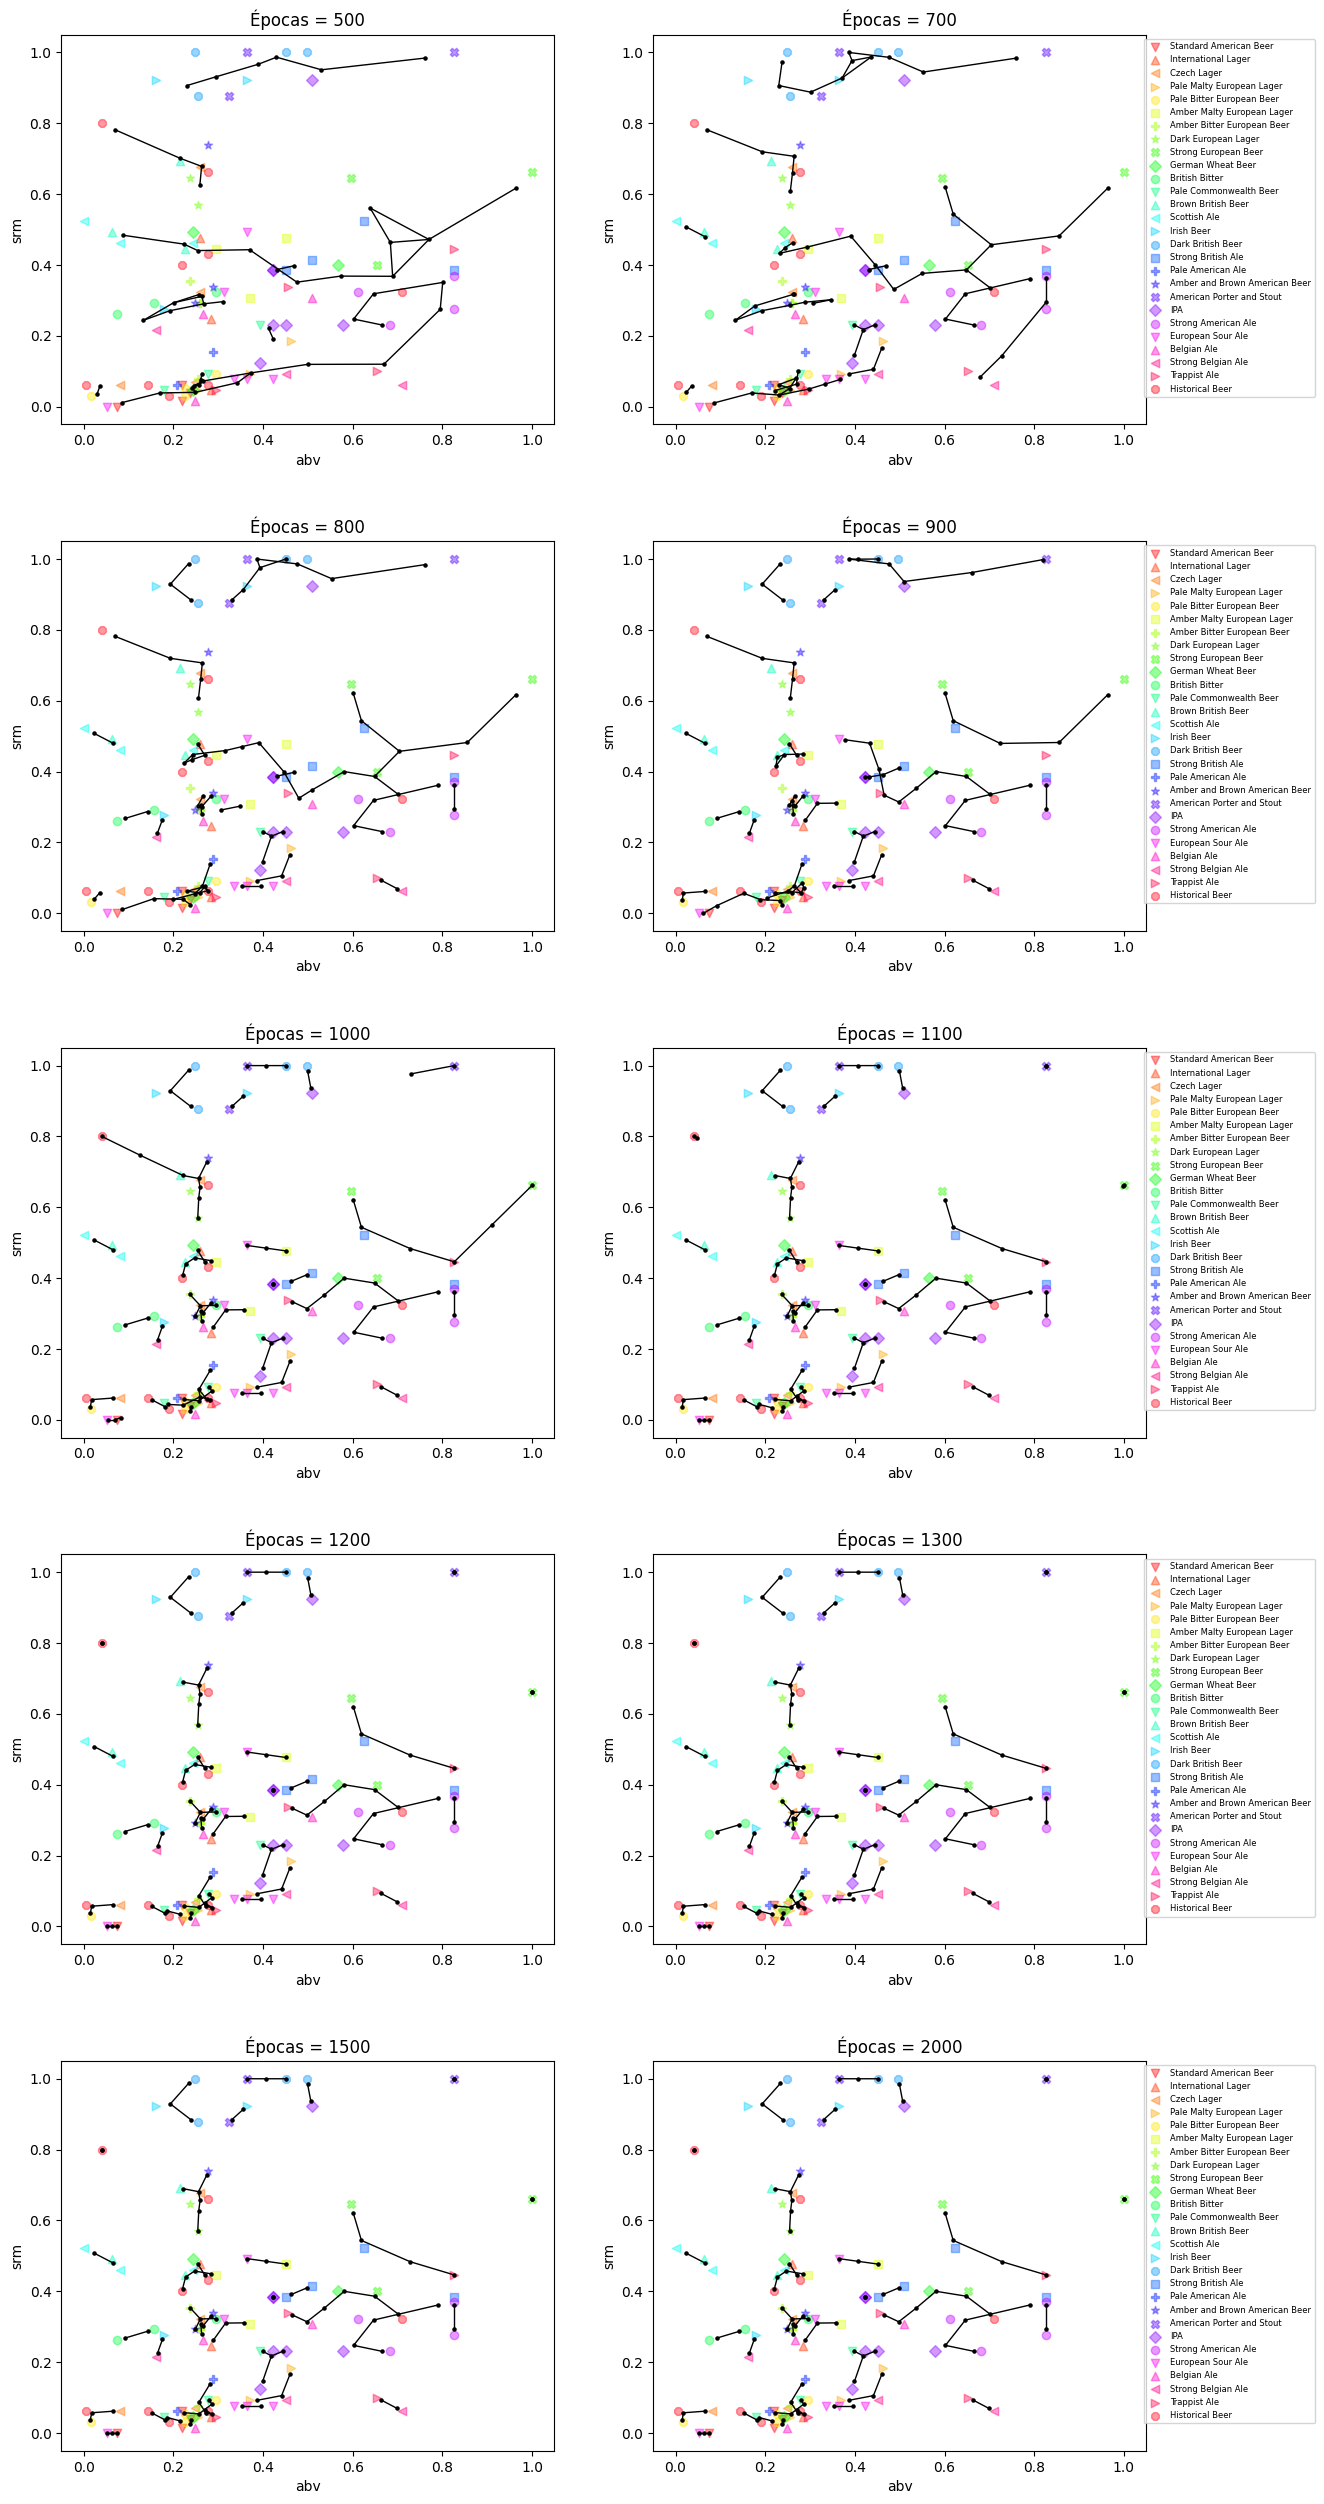

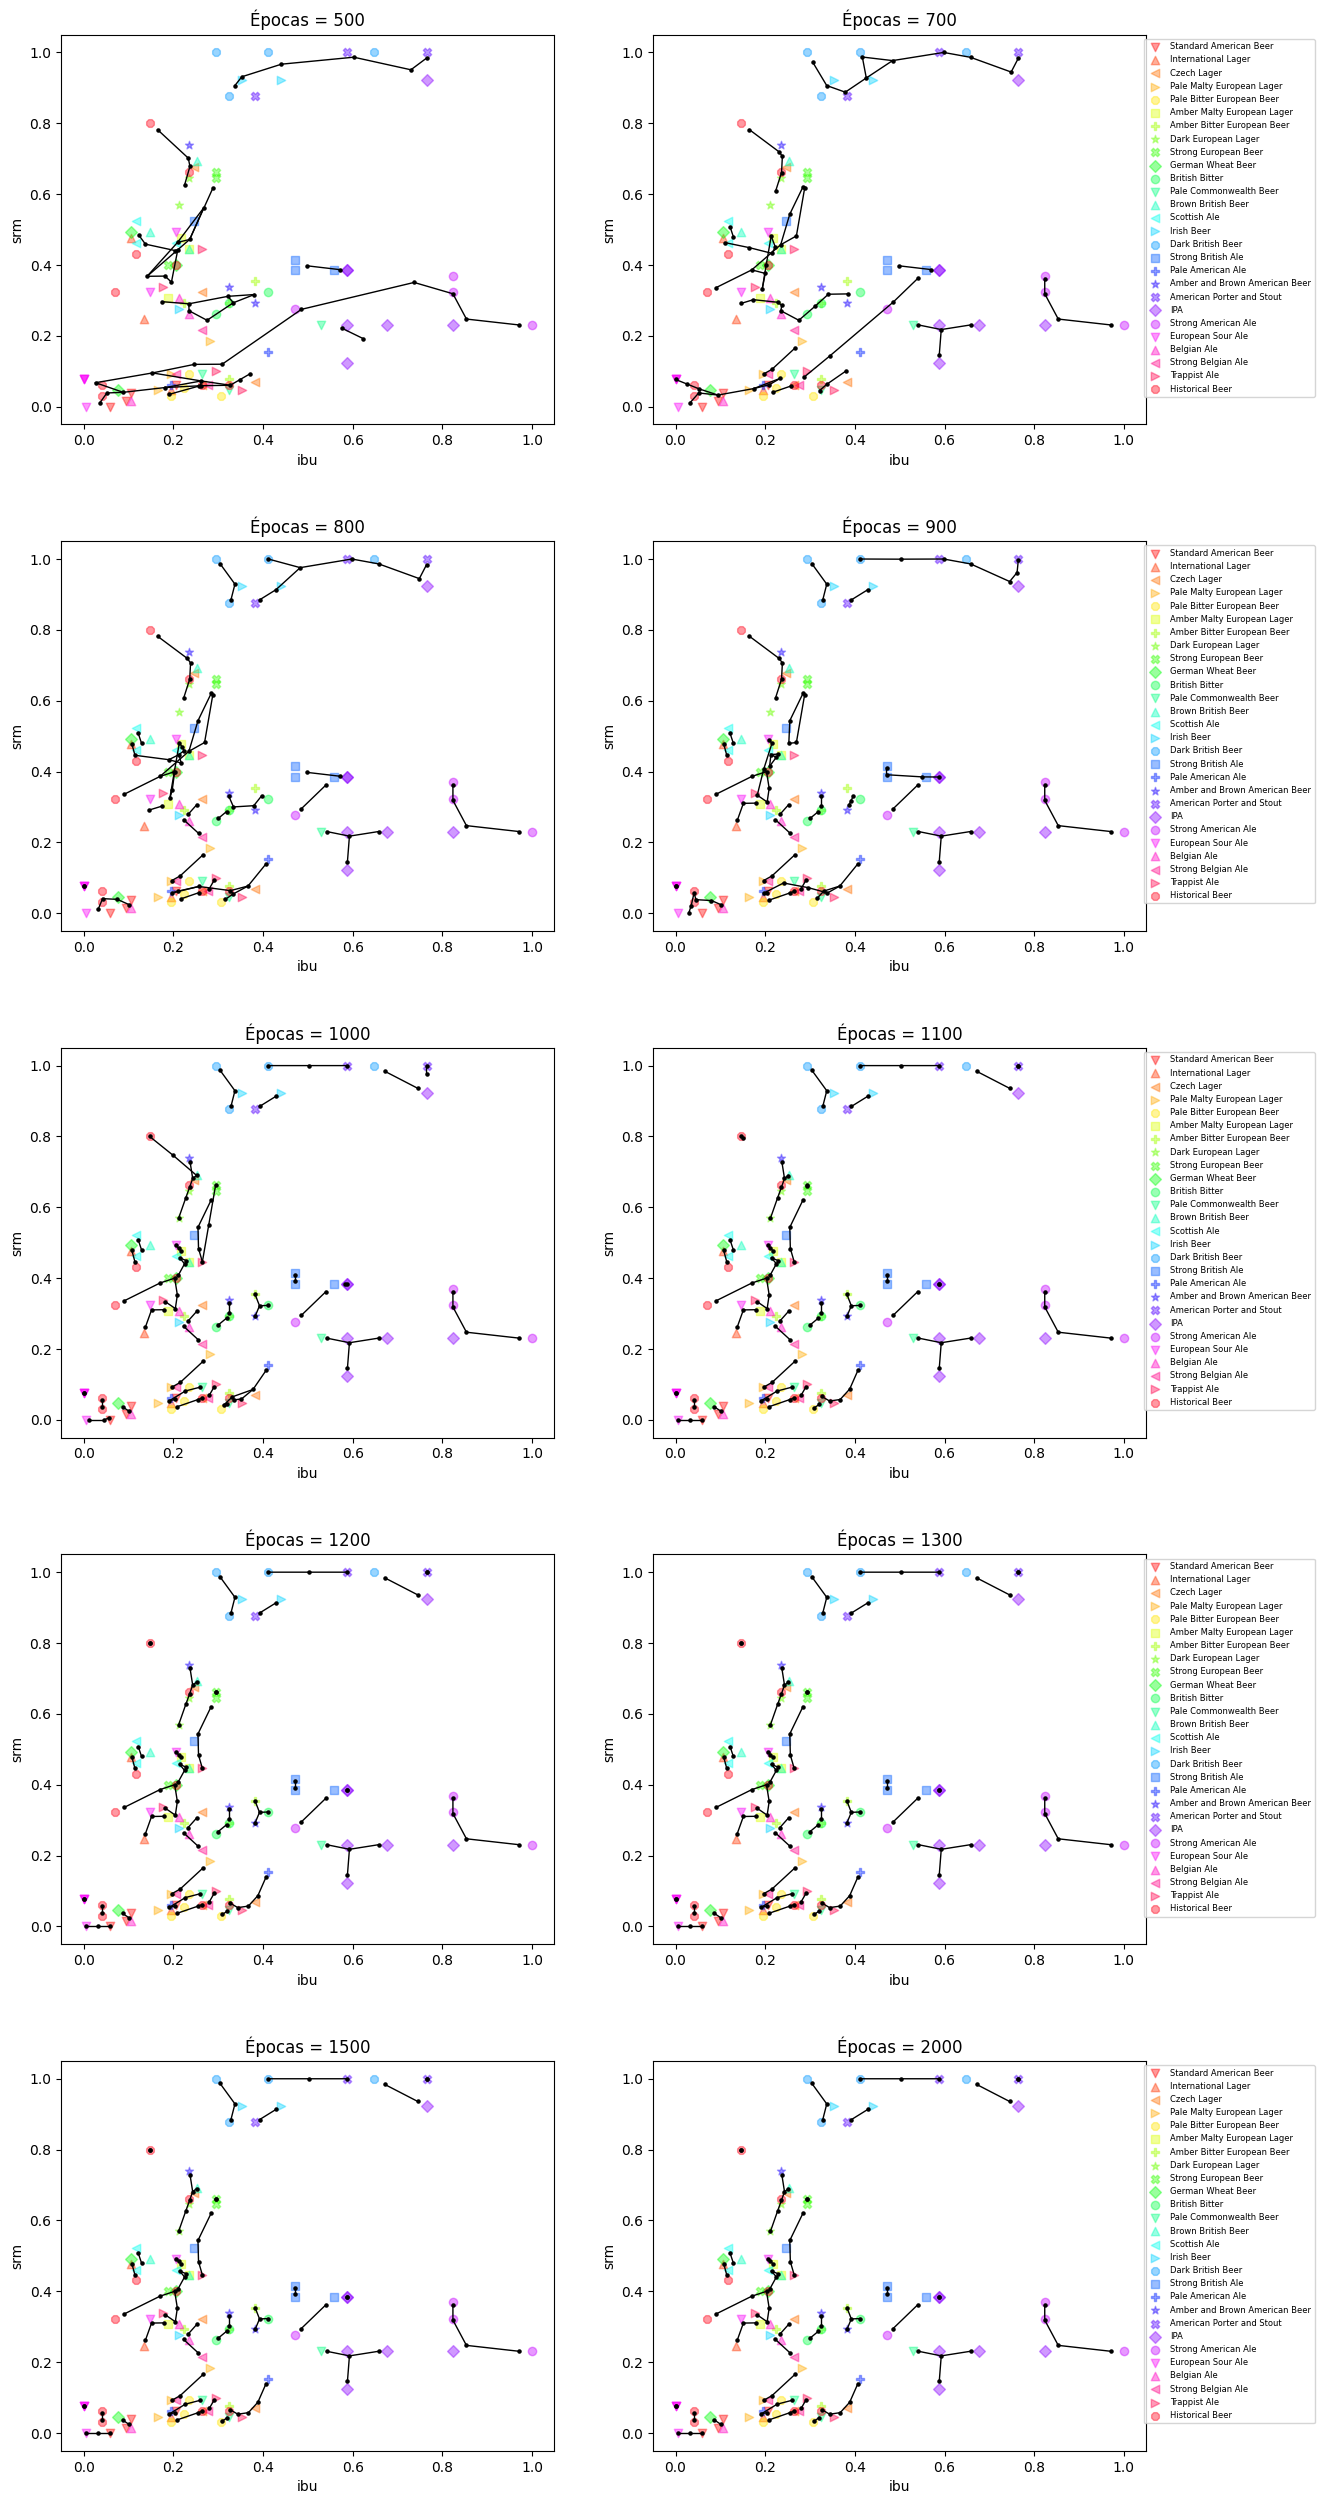

In [ ]:
new_max_num_super_styles = 100

print("Numero máximo de estilos = {}.".format(new_max_num_super_styles))
epochs_arr = [500, 700, 800, 900, 1000, 1100, 1200, 1300, 1500, 2000]
# epochs_arr = [250]

gng_models = [
    algorithms.GrowingNeuralGas(
        n_inputs = len(feature_names),
        n_start_nodes = 2, 
        max_nodes = new_max_num_super_styles
    ) for ep in epochs_arr
]

i=0
for gng_model in gng_models:
  gng_model.train(styles_mean[feature_names], epochs = epochs_arr[i])
  print("{} nós e {} arestas gerados em {} épocas".format(gng_model.graph.n_nodes, gng_model.graph.n_edges, epochs_arr[i]))
  i = i + 1

show_all_gng_models(gng_models,"Épocas = {value}", epochs_arr)


#### Teste 2 - Variação na Idade máxima das conexões
À partir do número de épocas ideal (1000) para estabilizar a quantidade ideal de neurônios e arestas, identificar se a variação deste parâmetro pode gerar melhores agrupamentos.

4 nós e 4 arestas geradas por idade máxima de arestas =7 


100 nós e 64 arestas geradas por idade máxima de arestas =8 


100 nós e 66 arestas geradas por idade máxima de arestas =9 


100 nós e 67 arestas geradas por idade máxima de arestas =10 


100 nós e 67 arestas geradas por idade máxima de arestas =50 


100 nós e 69 arestas geradas por idade máxima de arestas =100 


100 nós e 79 arestas geradas por idade máxima de arestas =300 


100 nós e 88 arestas geradas por idade máxima de arestas =500 


100 nós e 124 arestas geradas por idade máxima de arestas =1000 


100 nós e 152 arestas geradas por idade máxima de arestas =2000 


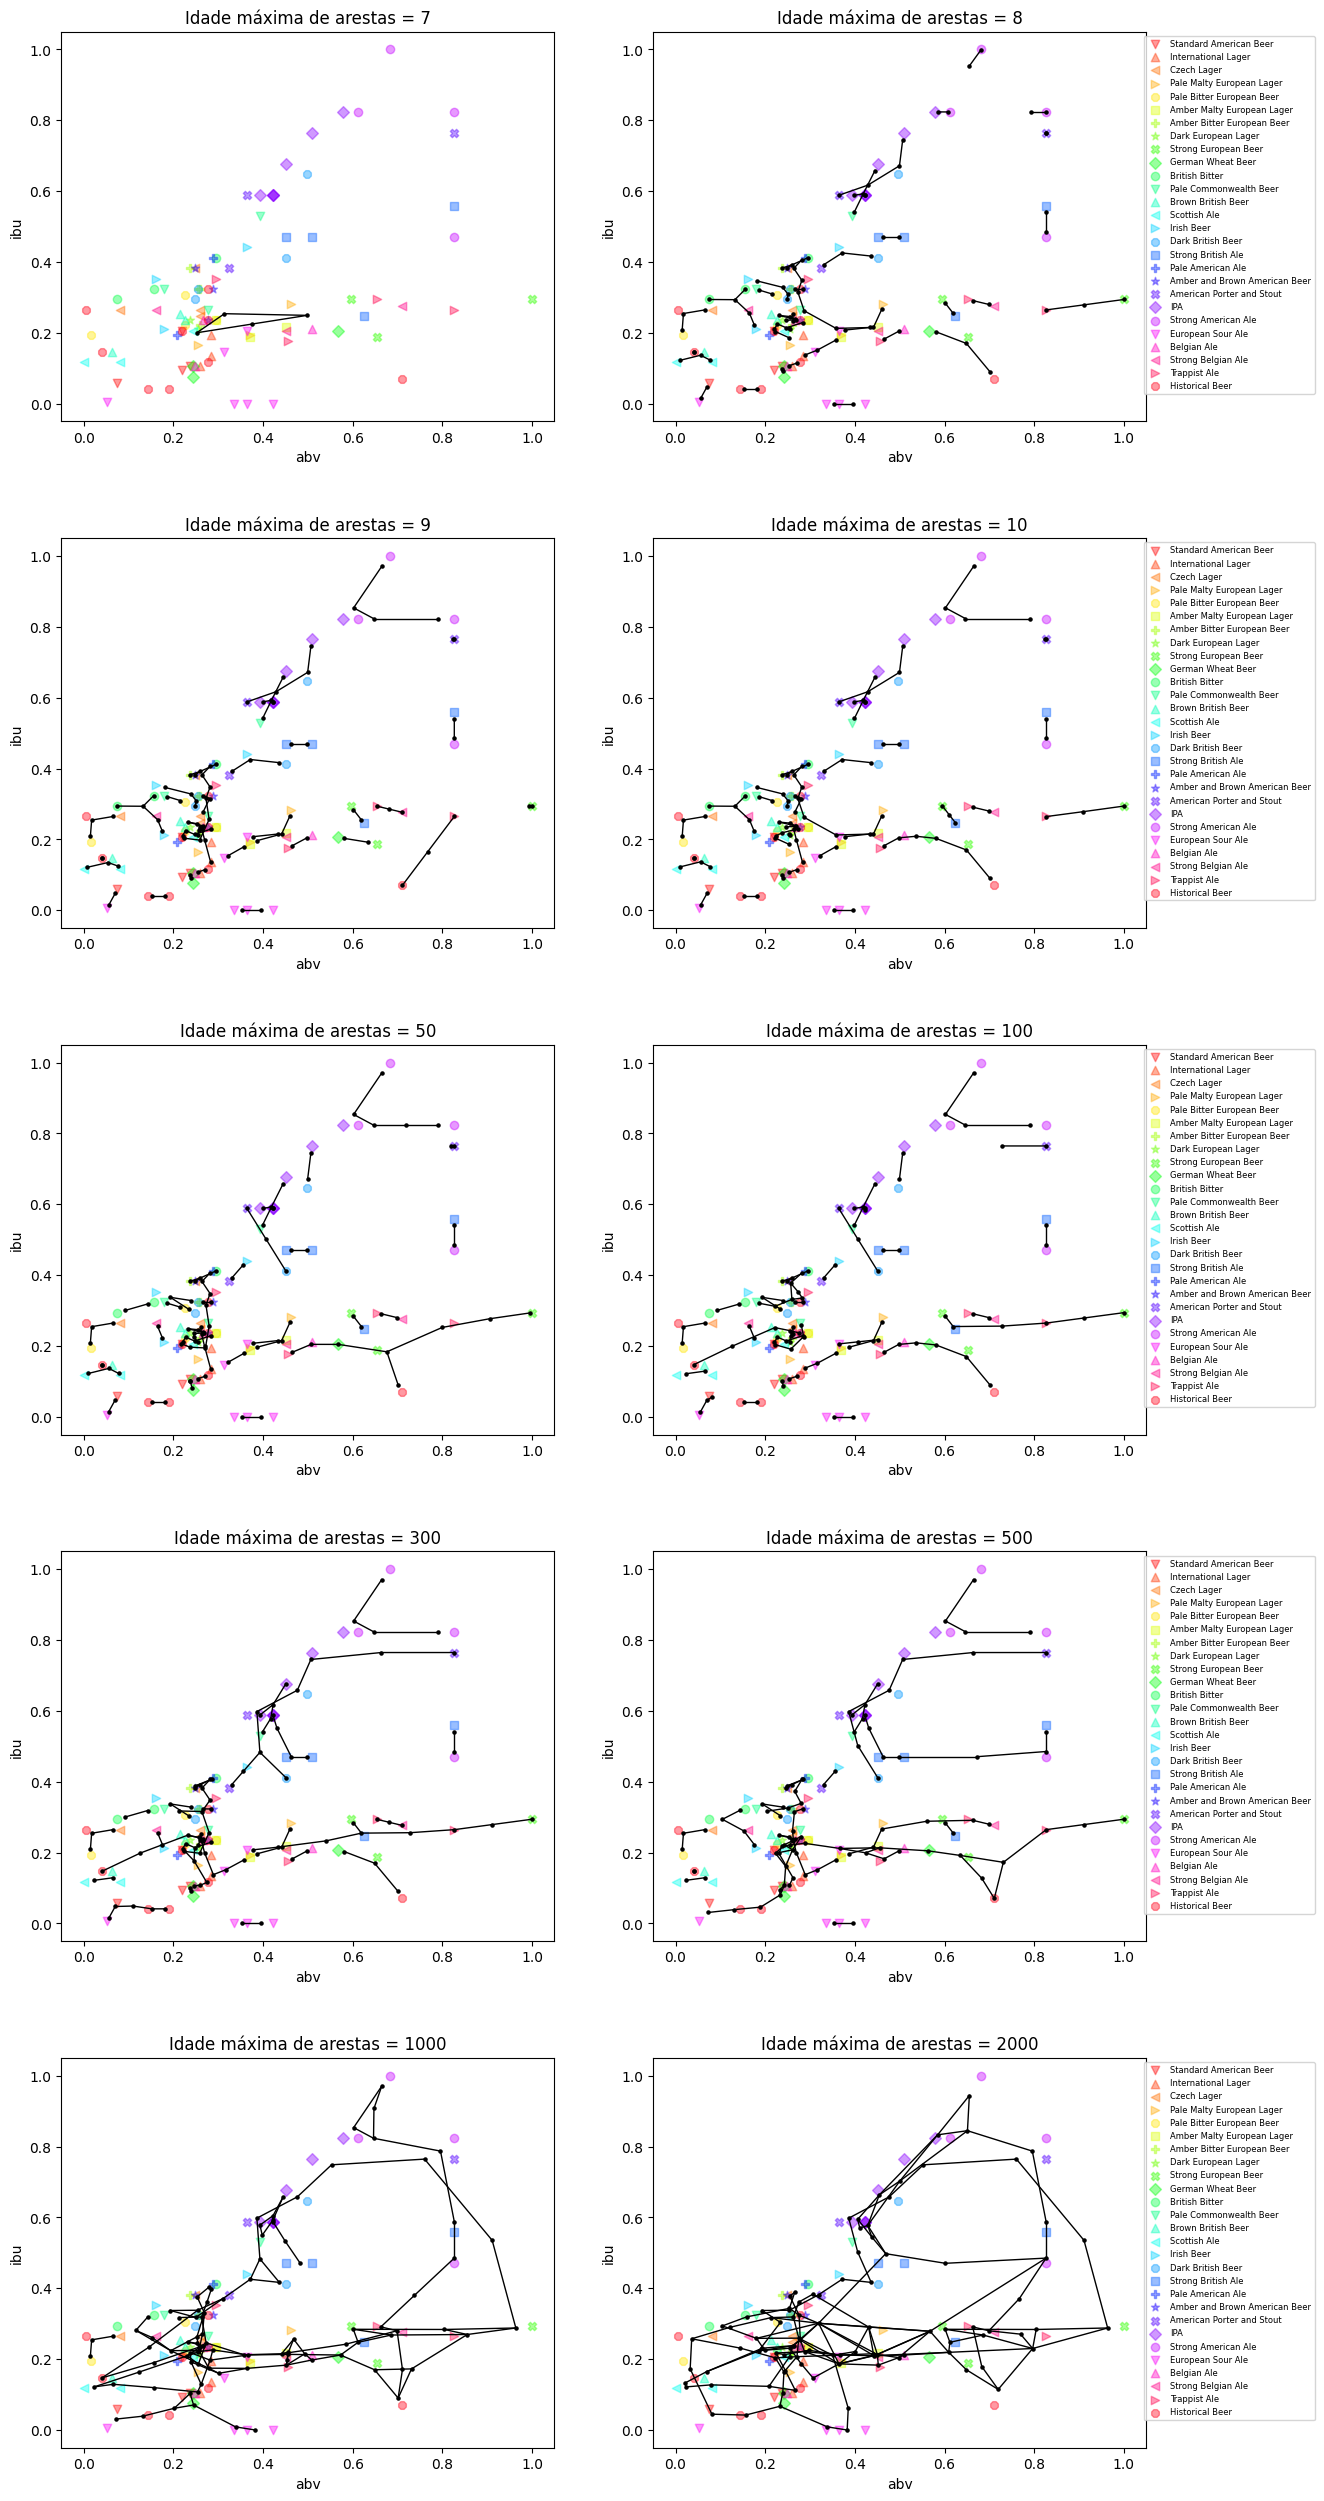

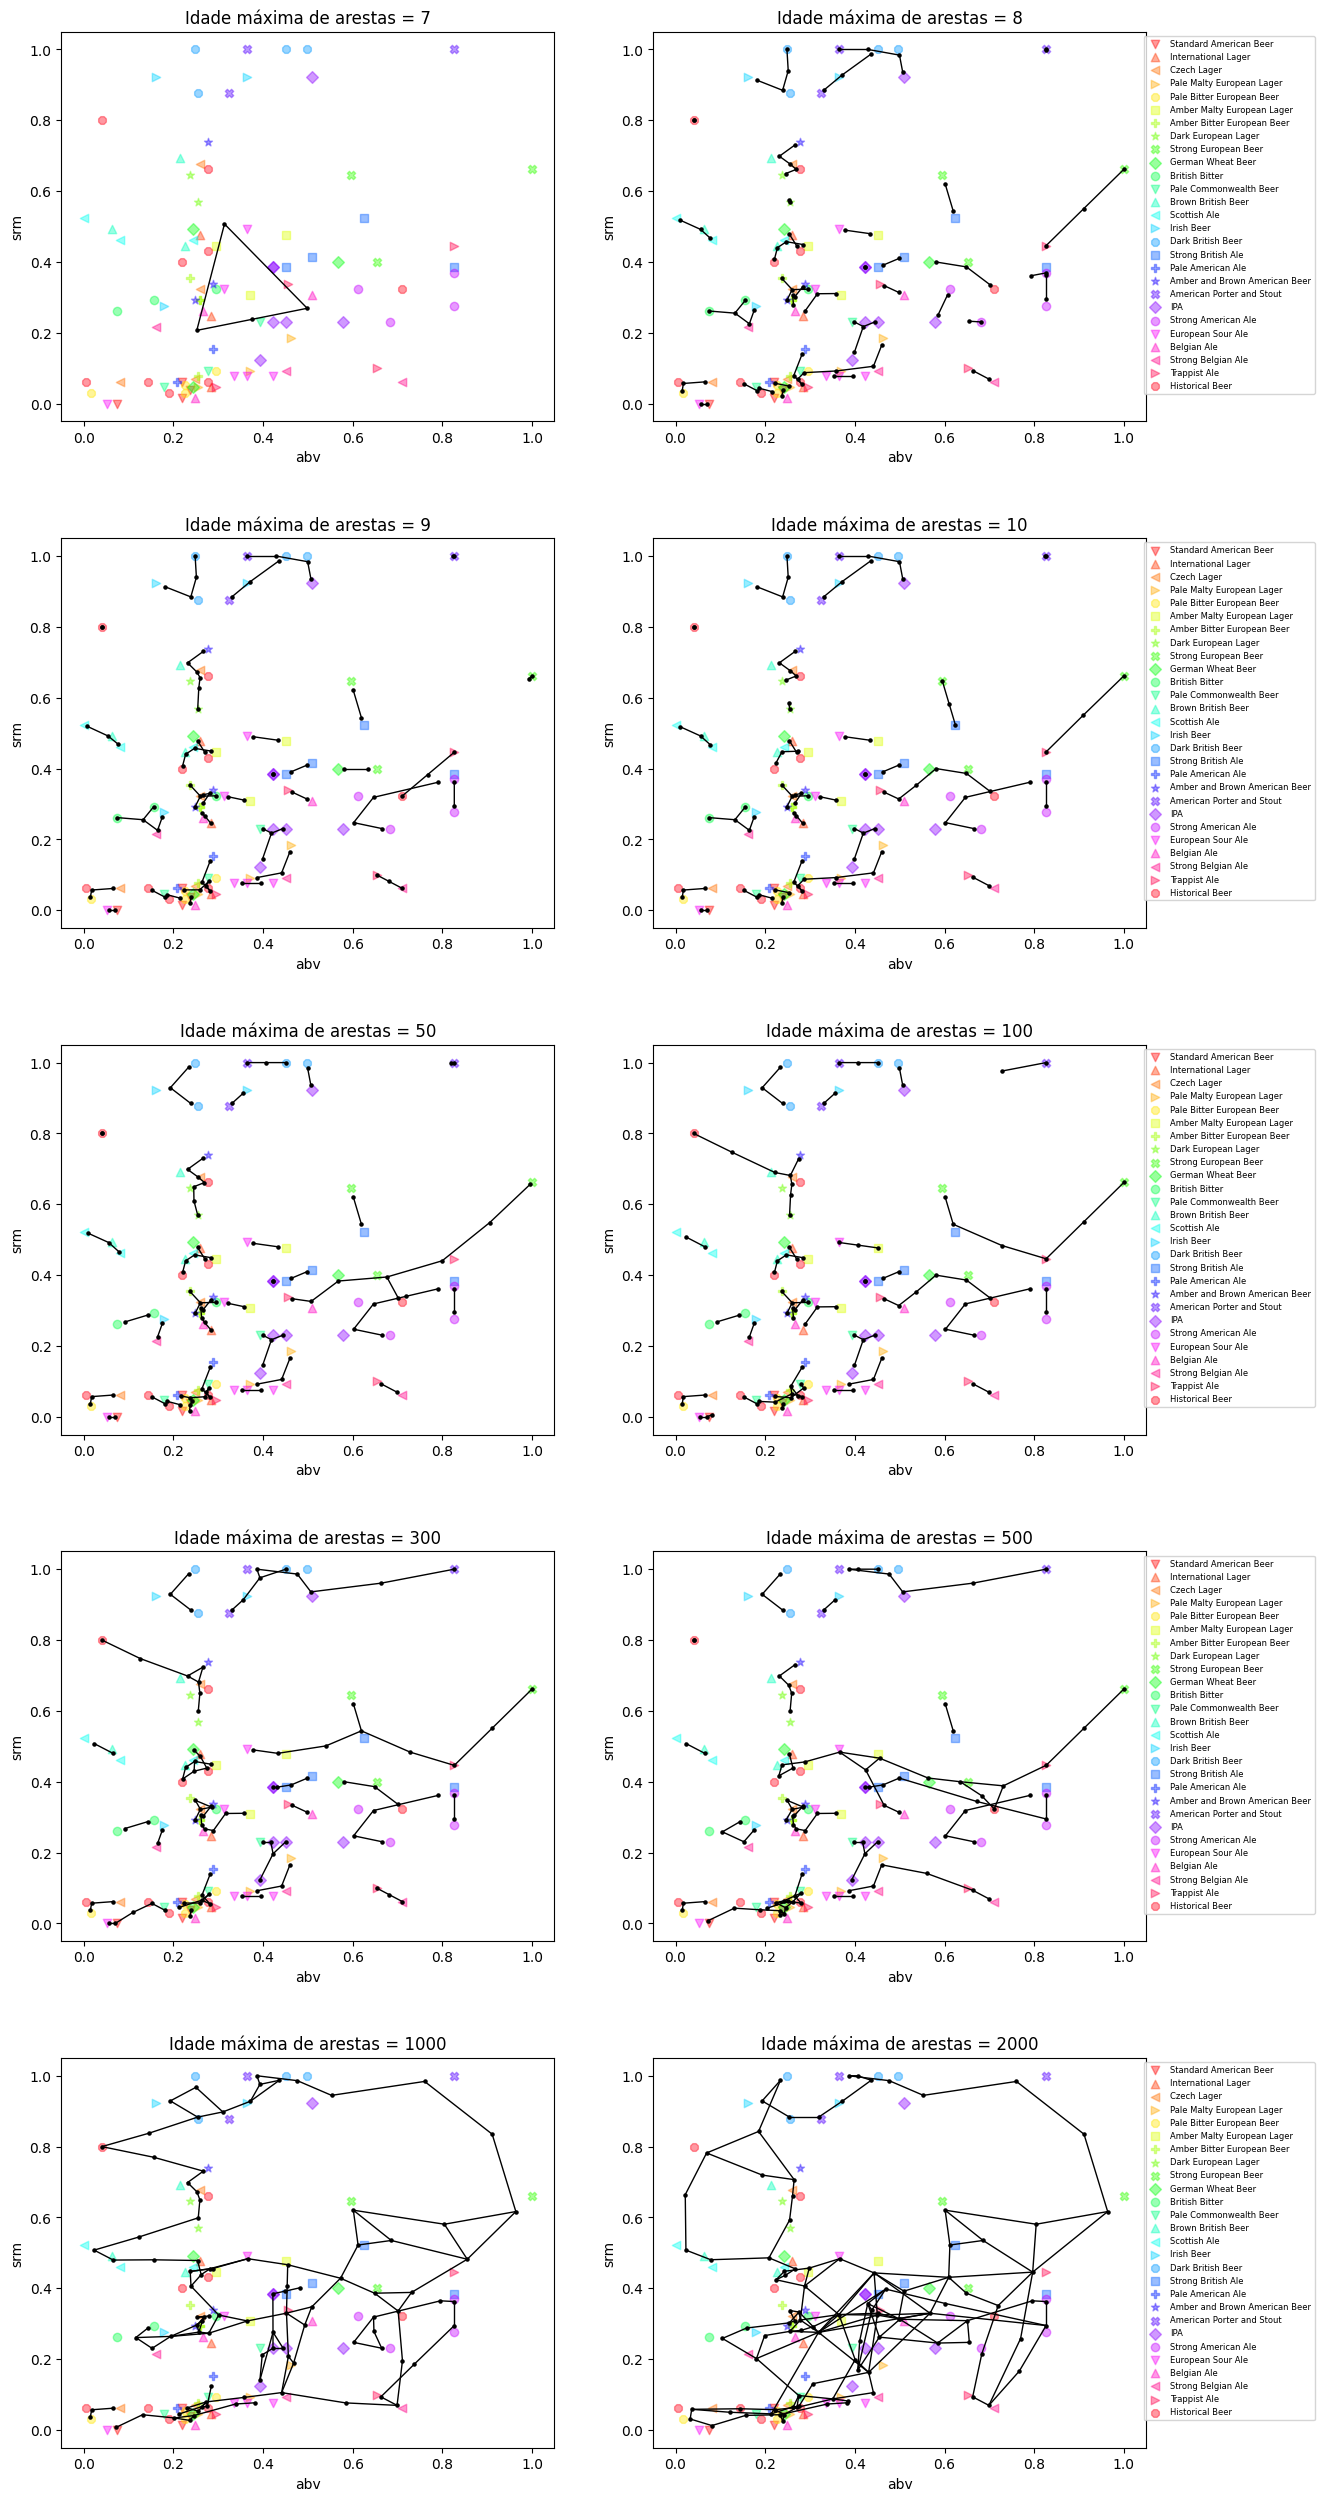

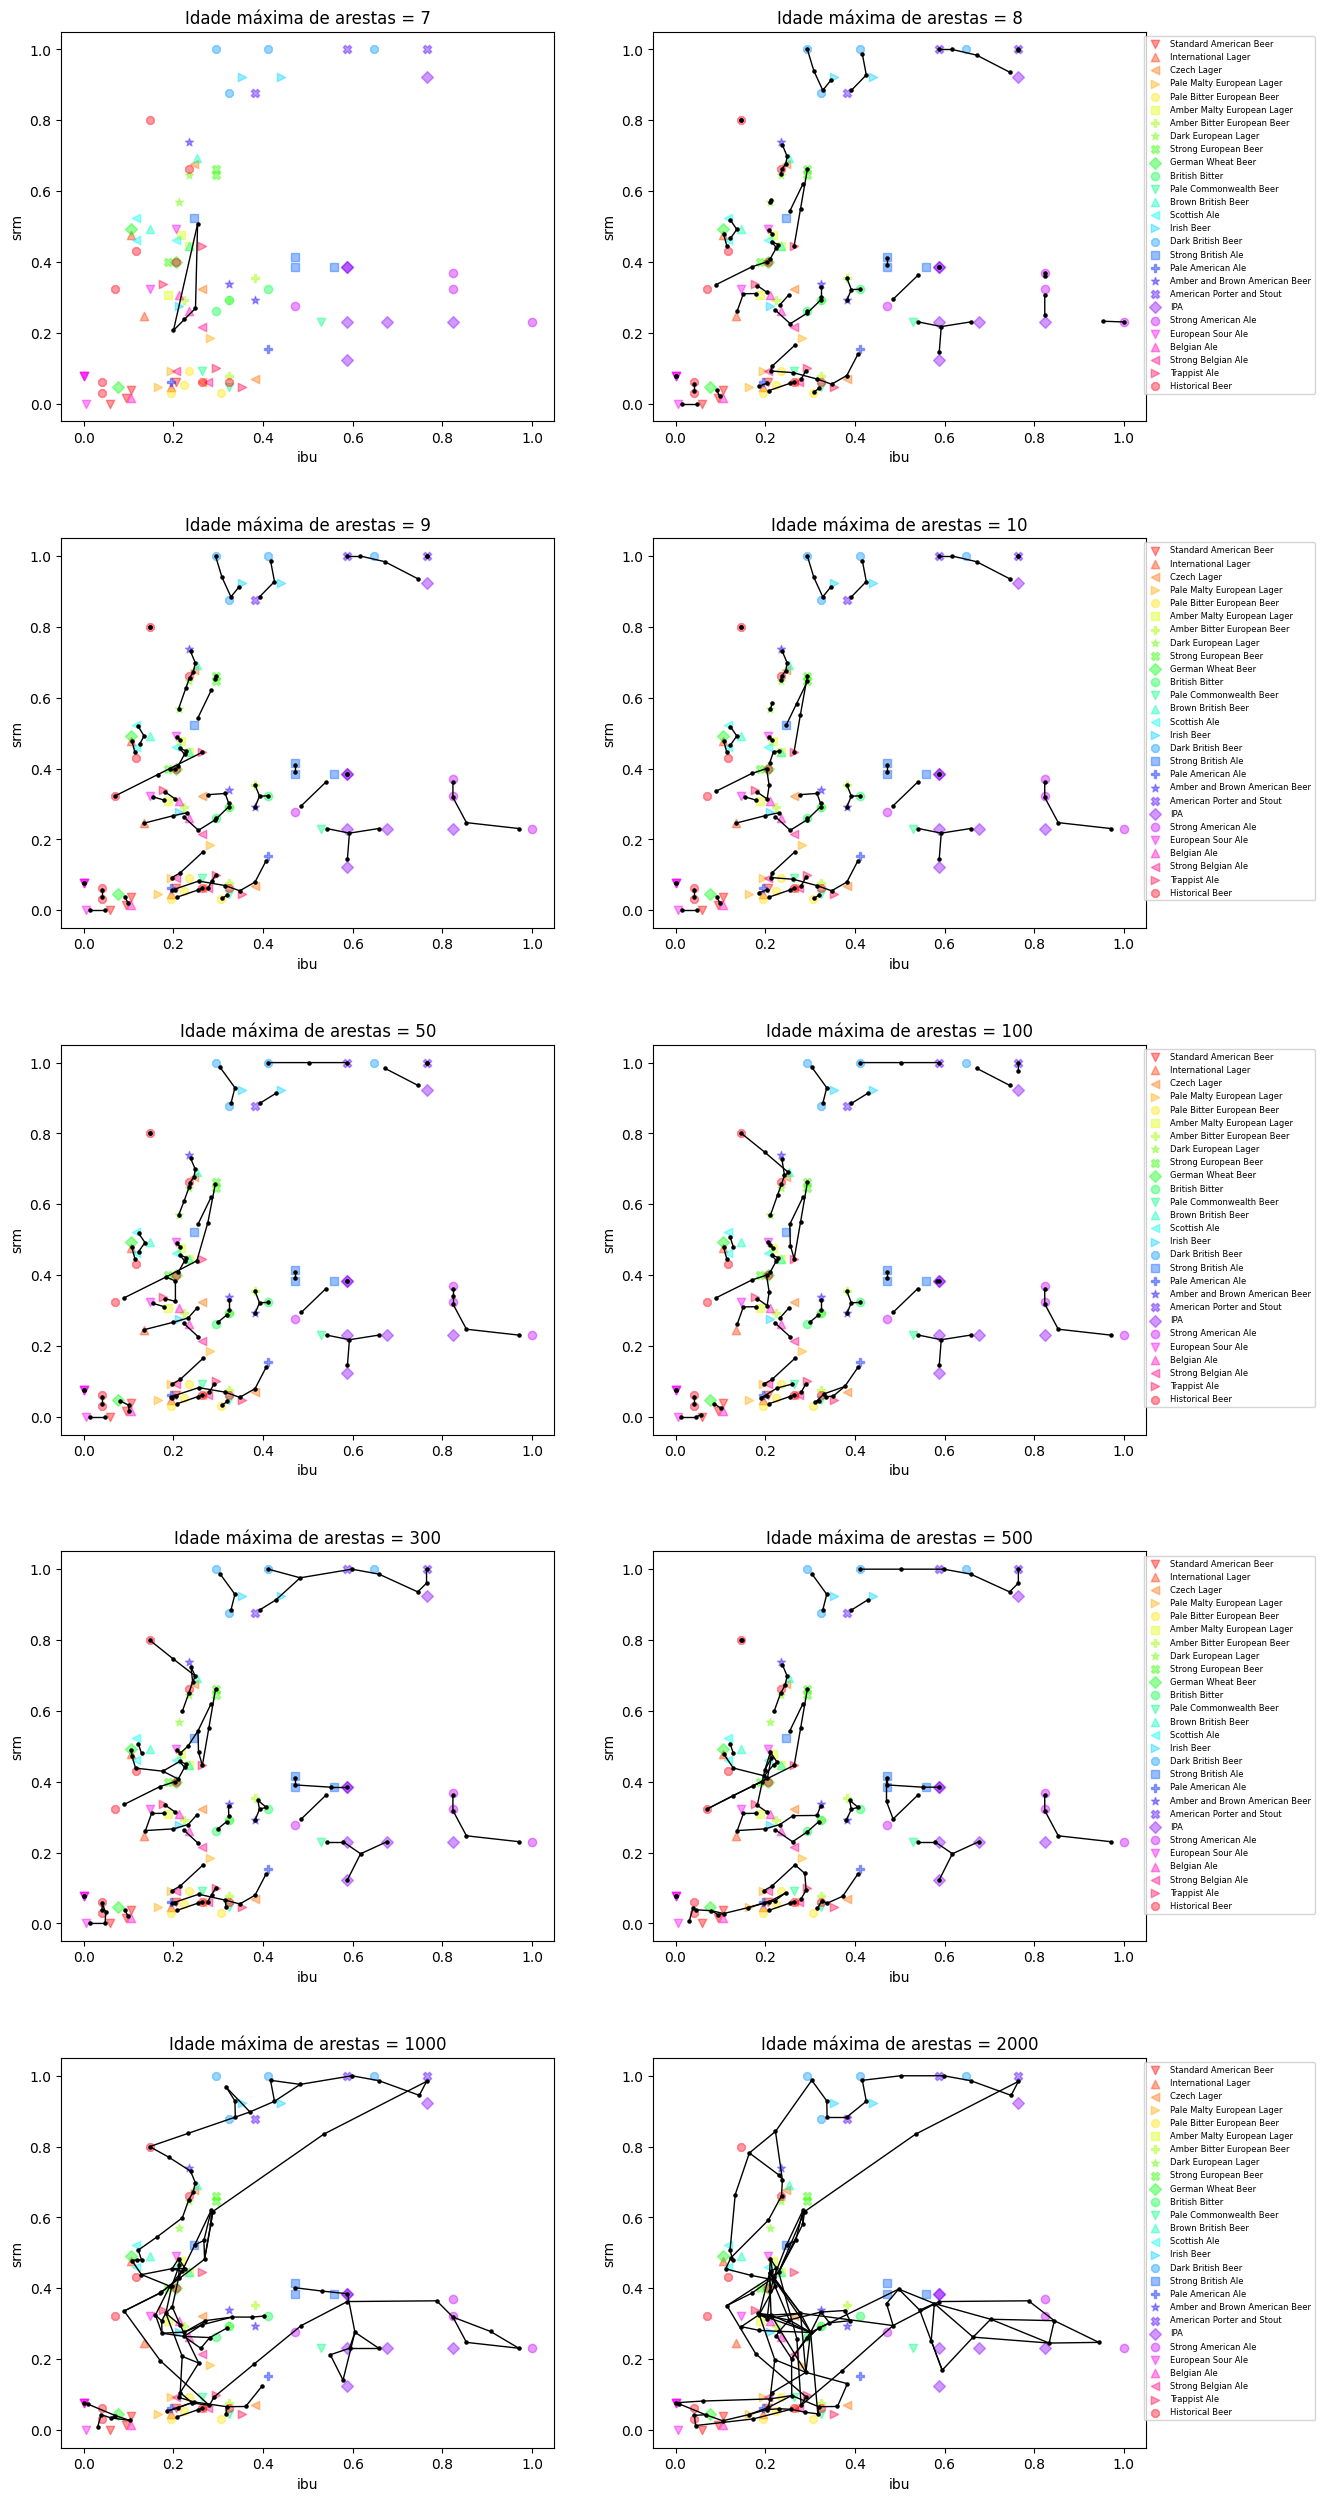

In [ ]:
test2_max_edge_age = [ 7, 8, 9, 10, 50, 100, 300, 500, 1000, 2000]  # padrão 100

epochs=1000
gng_models = [
    algorithms.GrowingNeuralGas(
        n_inputs = len(feature_names),
        n_start_nodes = 2, 
        max_nodes = new_max_num_super_styles,
        max_edge_age = max_age 
    ) for max_age in test2_max_edge_age
]

i=0
for gng_model in gng_models:
  gng_model.train(styles_mean[feature_names], epochs = epochs)
  print("{} nós e {} arestas geradas por idade máxima de arestas ={} ".format(gng_model.graph.n_nodes, gng_model.graph.n_edges, test2_max_edge_age[i]))
  i = i + 1

show_all_gng_models(gng_models,"Idade máxima de arestas = {value}", test2_max_edge_age)


#### Teste 3 - Variação de tempo para adição de novos neurônios
À partir do número de épocas ideal (1000) para estabilizar a quantidade ideal de neurônios e arestas, identificar se a variação de tempo para adição de novos neurônios pode gerar mehores agrupamentos

100 nós e 71 arestas geradas usando 5 iterações antes de adicionar um neurônio


100 nós e 68 arestas geradas usando 10 iterações antes de adicionar um neurônio


100 nós e 73 arestas geradas usando 100 iterações antes de adicionar um neurônio


100 nós e 65 arestas geradas usando 500 iterações antes de adicionar um neurônio


100 nós e 66 arestas geradas usando 750 iterações antes de adicionar um neurônio


100 nós e 65 arestas geradas usando 900 iterações antes de adicionar um neurônio


100 nós e 69 arestas geradas usando 1000 iterações antes de adicionar um neurônio


92 nós e 65 arestas geradas usando 1100 iterações antes de adicionar um neurônio


82 nós e 65 arestas geradas usando 1250 iterações antes de adicionar um neurônio


68 nós e 59 arestas geradas usando 1500 iterações antes de adicionar um neurônio


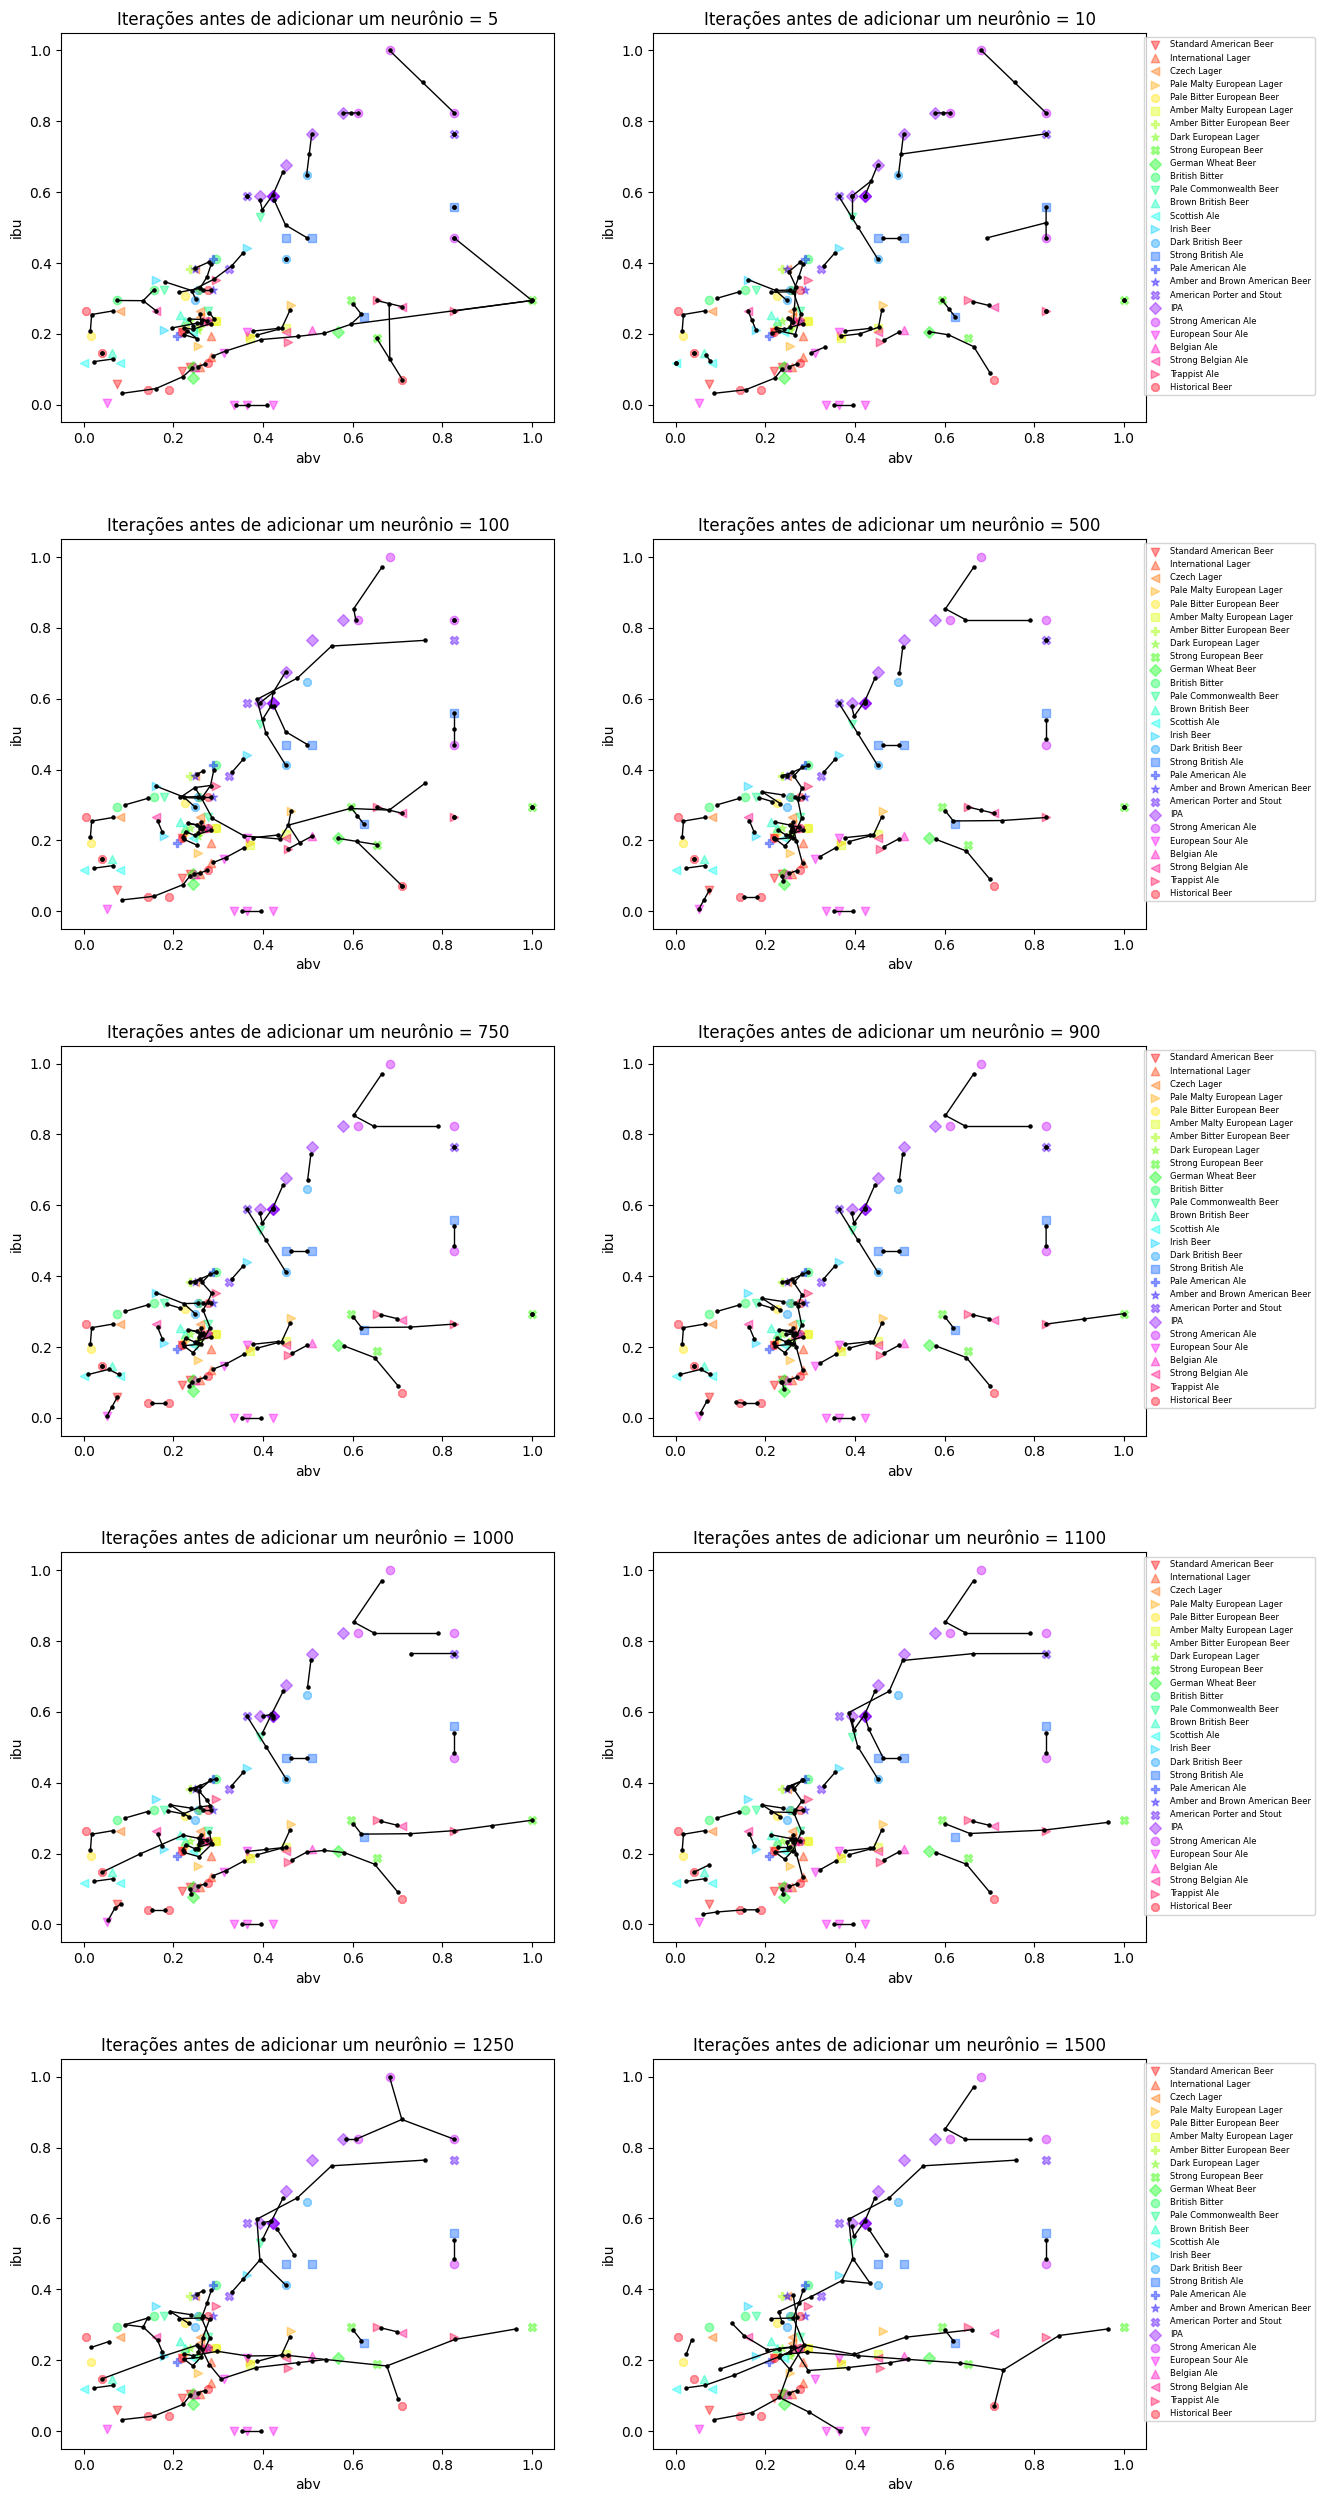

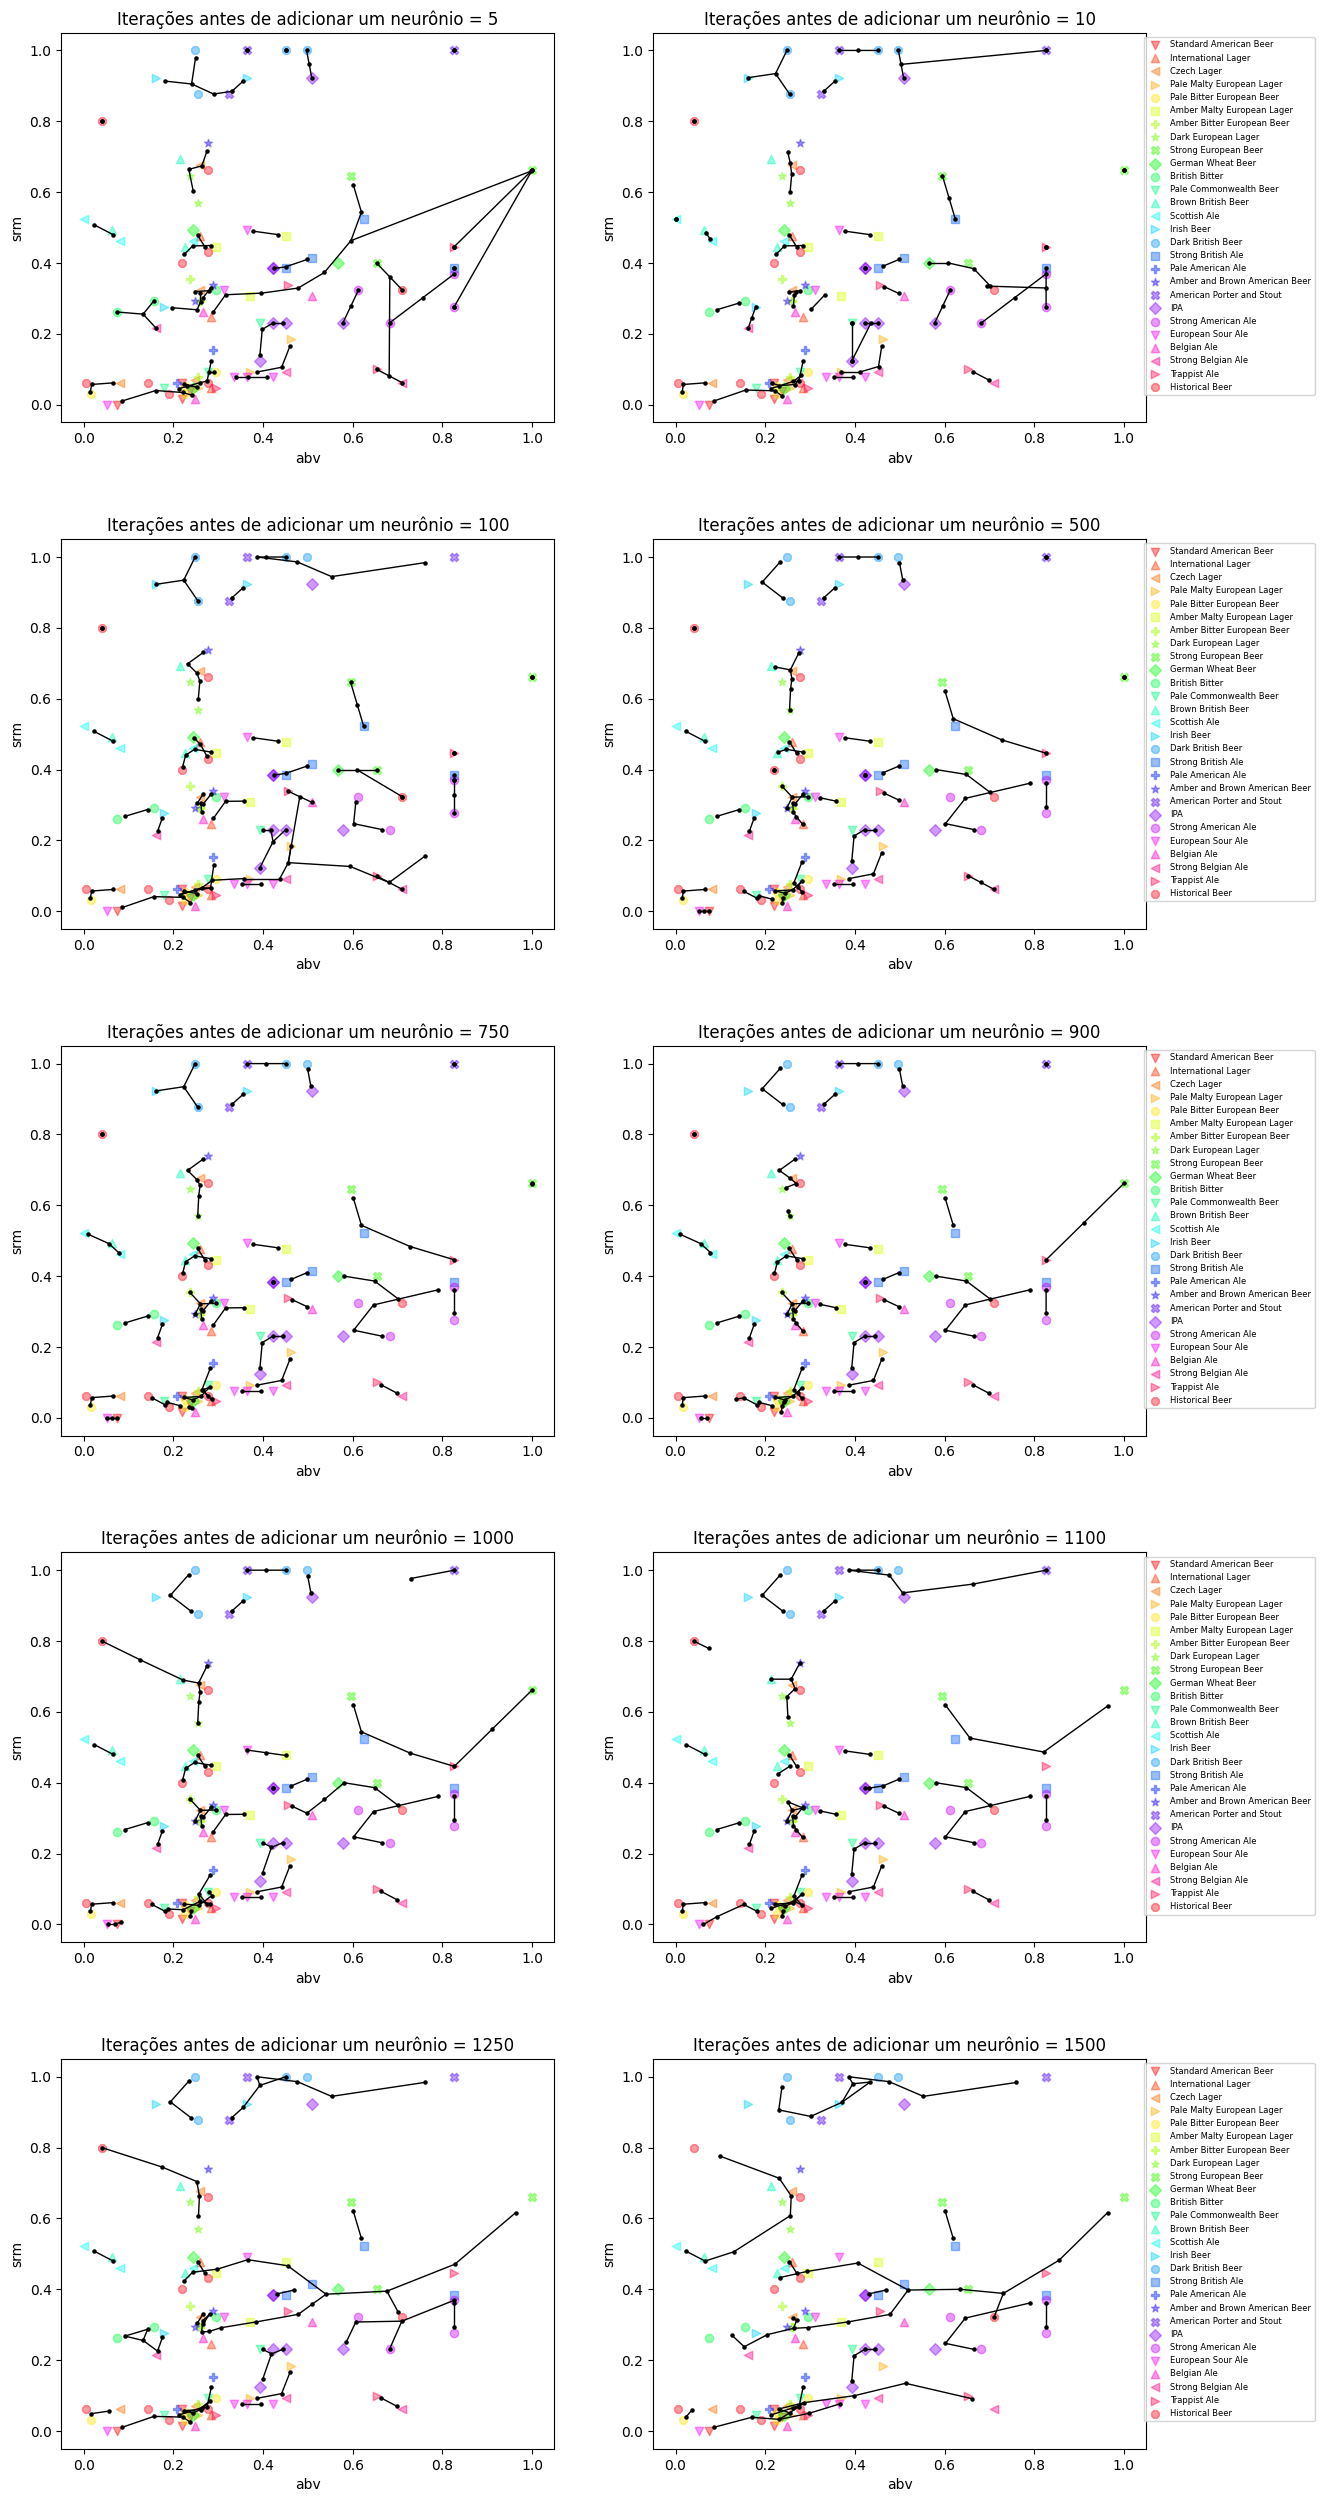

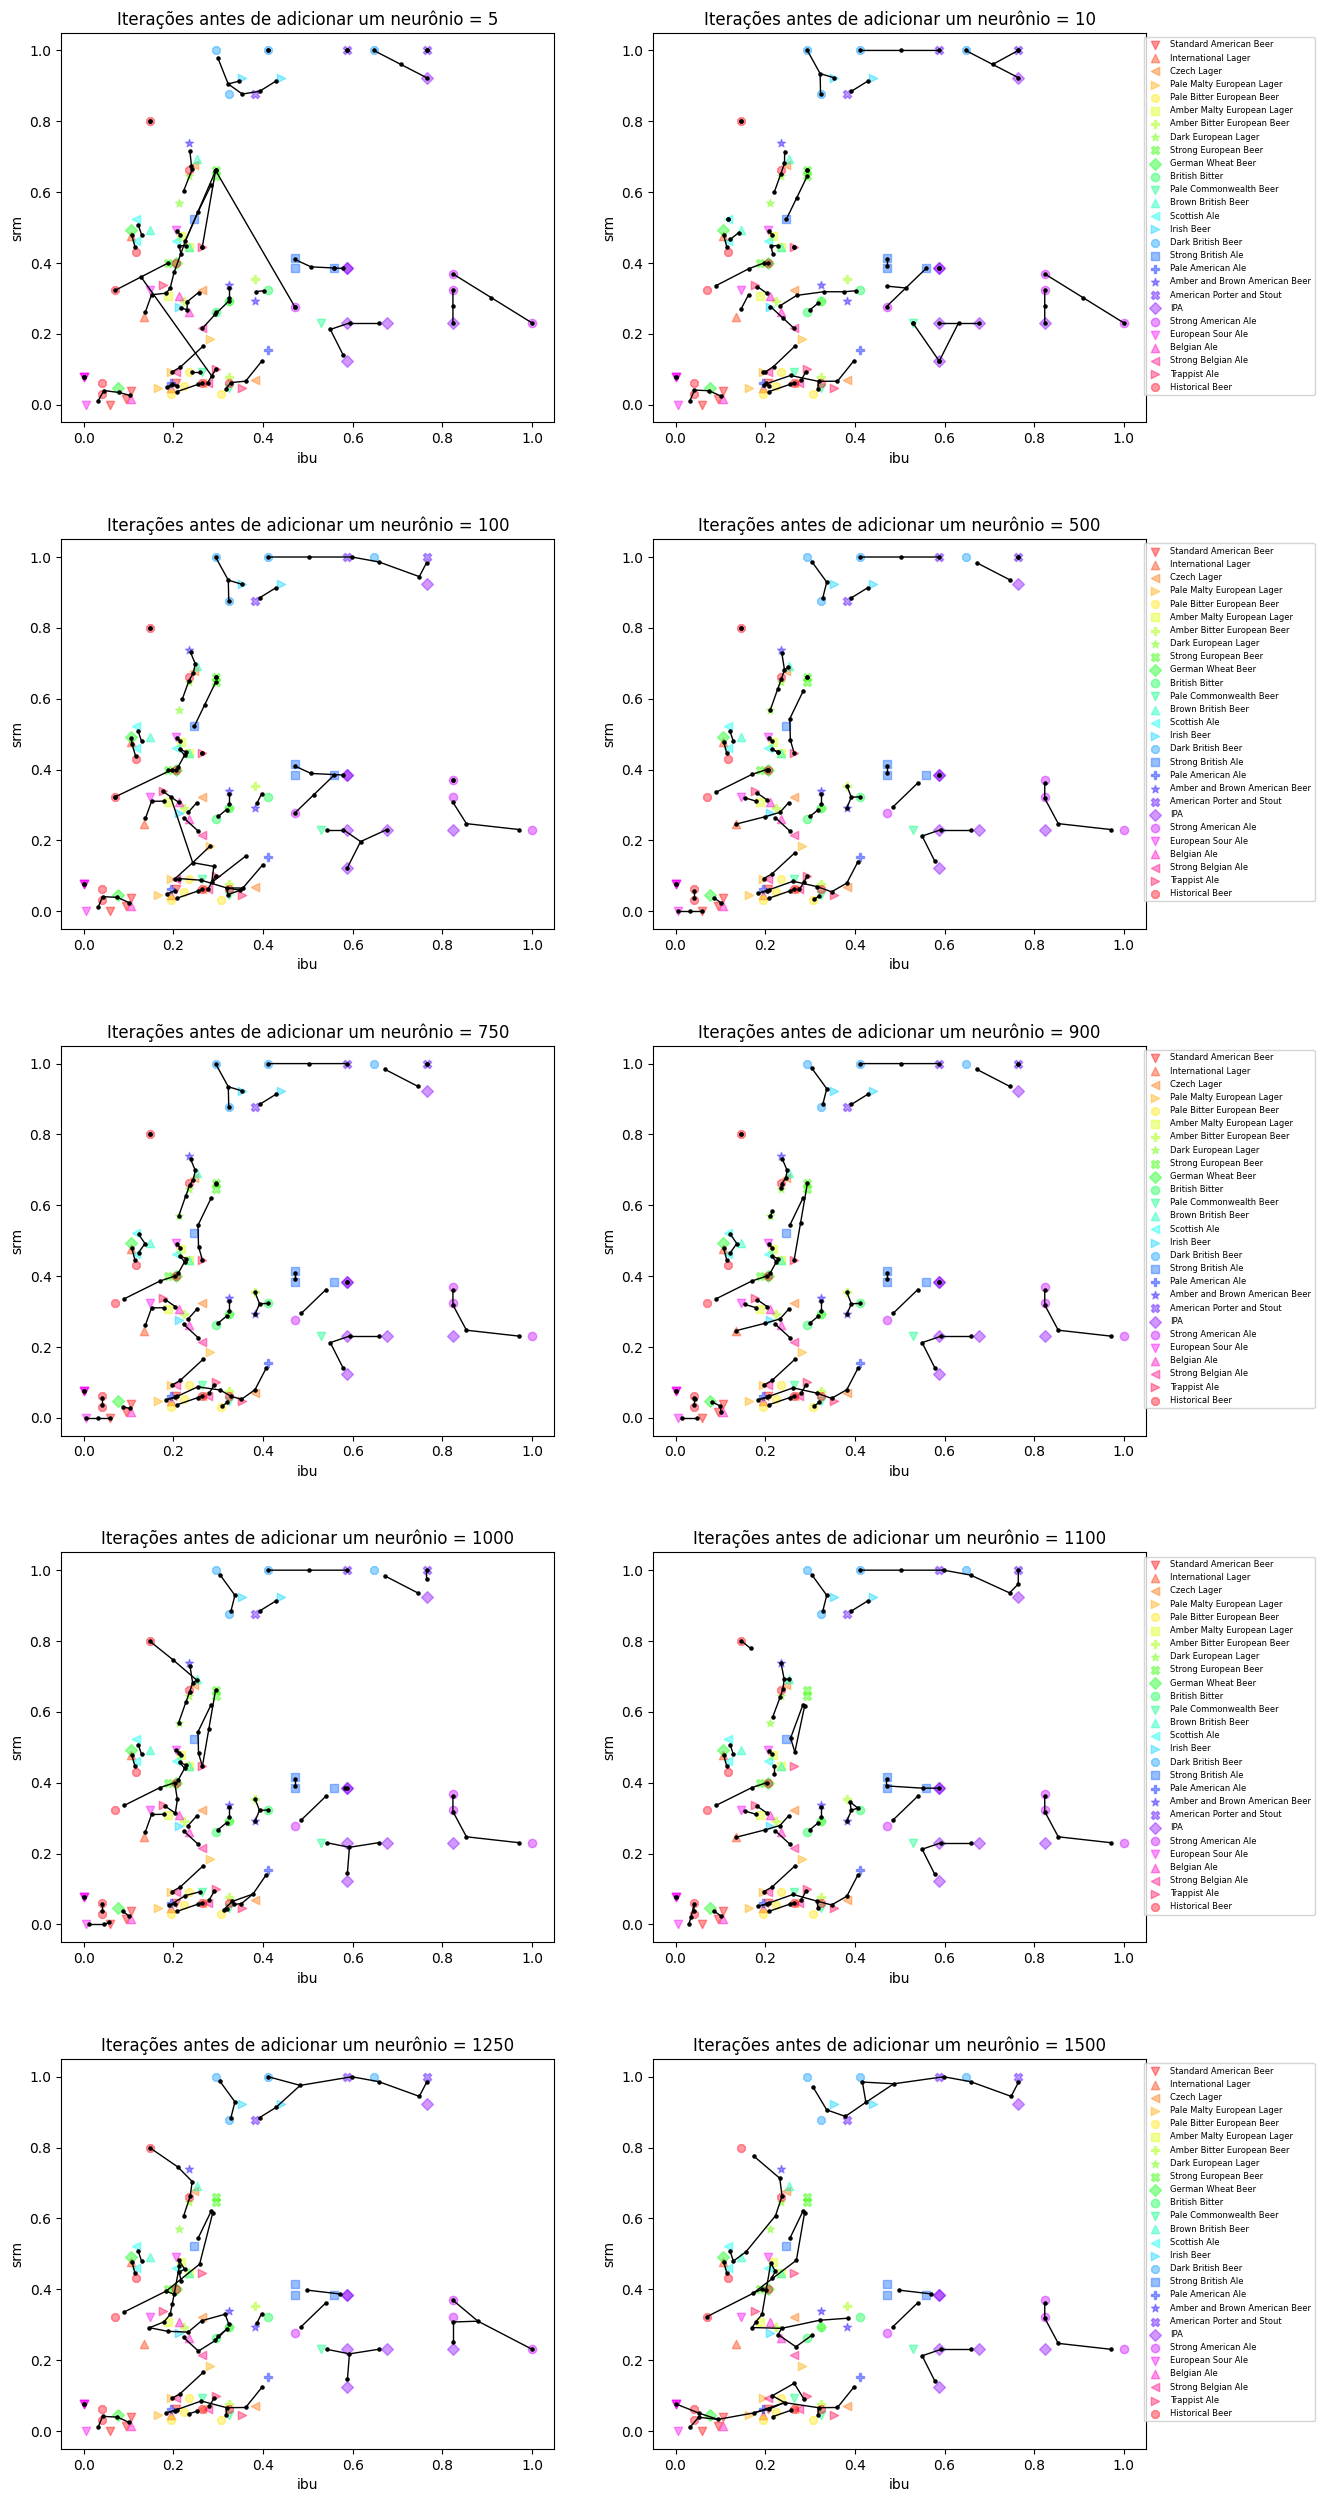

In [ ]:
test3_n_iter_before_neuron_added = [5, 10, 100, 500, 750, 900, 1000, 1100, 1250, 1500]  # padrão = 1000

epochs=1000
gng_models = [
    algorithms.GrowingNeuralGas(
        n_inputs = len(feature_names),
        n_start_nodes = 2, 
        max_nodes = new_max_num_super_styles,
        n_iter_before_neuron_added = max_n_inter
    ) for max_n_inter in test3_n_iter_before_neuron_added
]

i=0
for gng_model in gng_models:
  gng_model.train(styles_mean[feature_names], epochs = epochs)
  print("{} nós e {} arestas geradas usando {} iterações antes de adicionar um neurônio".format(gng_model.graph.n_nodes, gng_model.graph.n_edges, test3_n_iter_before_neuron_added[i]))
  i = i + 1

show_all_gng_models(gng_models,"Iterações antes de adicionar um neurônio = {value}", test3_n_iter_before_neuron_added)


#### Teste 4 - Variação da distância mínima para atualização
À partir do número de épocas ideal (1000) para estabilizar a quantidade ideal de neurônios e arestas, identificar se a variação da distância mínima para atualização pode gerar mehores agrupamentos

100 nós e 69 arestas geradas usando 0 como distância mínima de atualização de neurônios


100 nós e 67 arestas geradas usando 0.05 como distância mínima de atualização de neurônios


99 nós e 70 arestas geradas usando 0.1 como distância mínima de atualização de neurônios


68 nós e 56 arestas geradas usando 0.2 como distância mínima de atualização de neurônios


36 nós e 49 arestas geradas usando 0.3 como distância mínima de atualização de neurônios


19 nós e 29 arestas geradas usando 0.4 como distância mínima de atualização de neurônios


11 nós e 16 arestas geradas usando 0.5 como distância mínima de atualização de neurônios


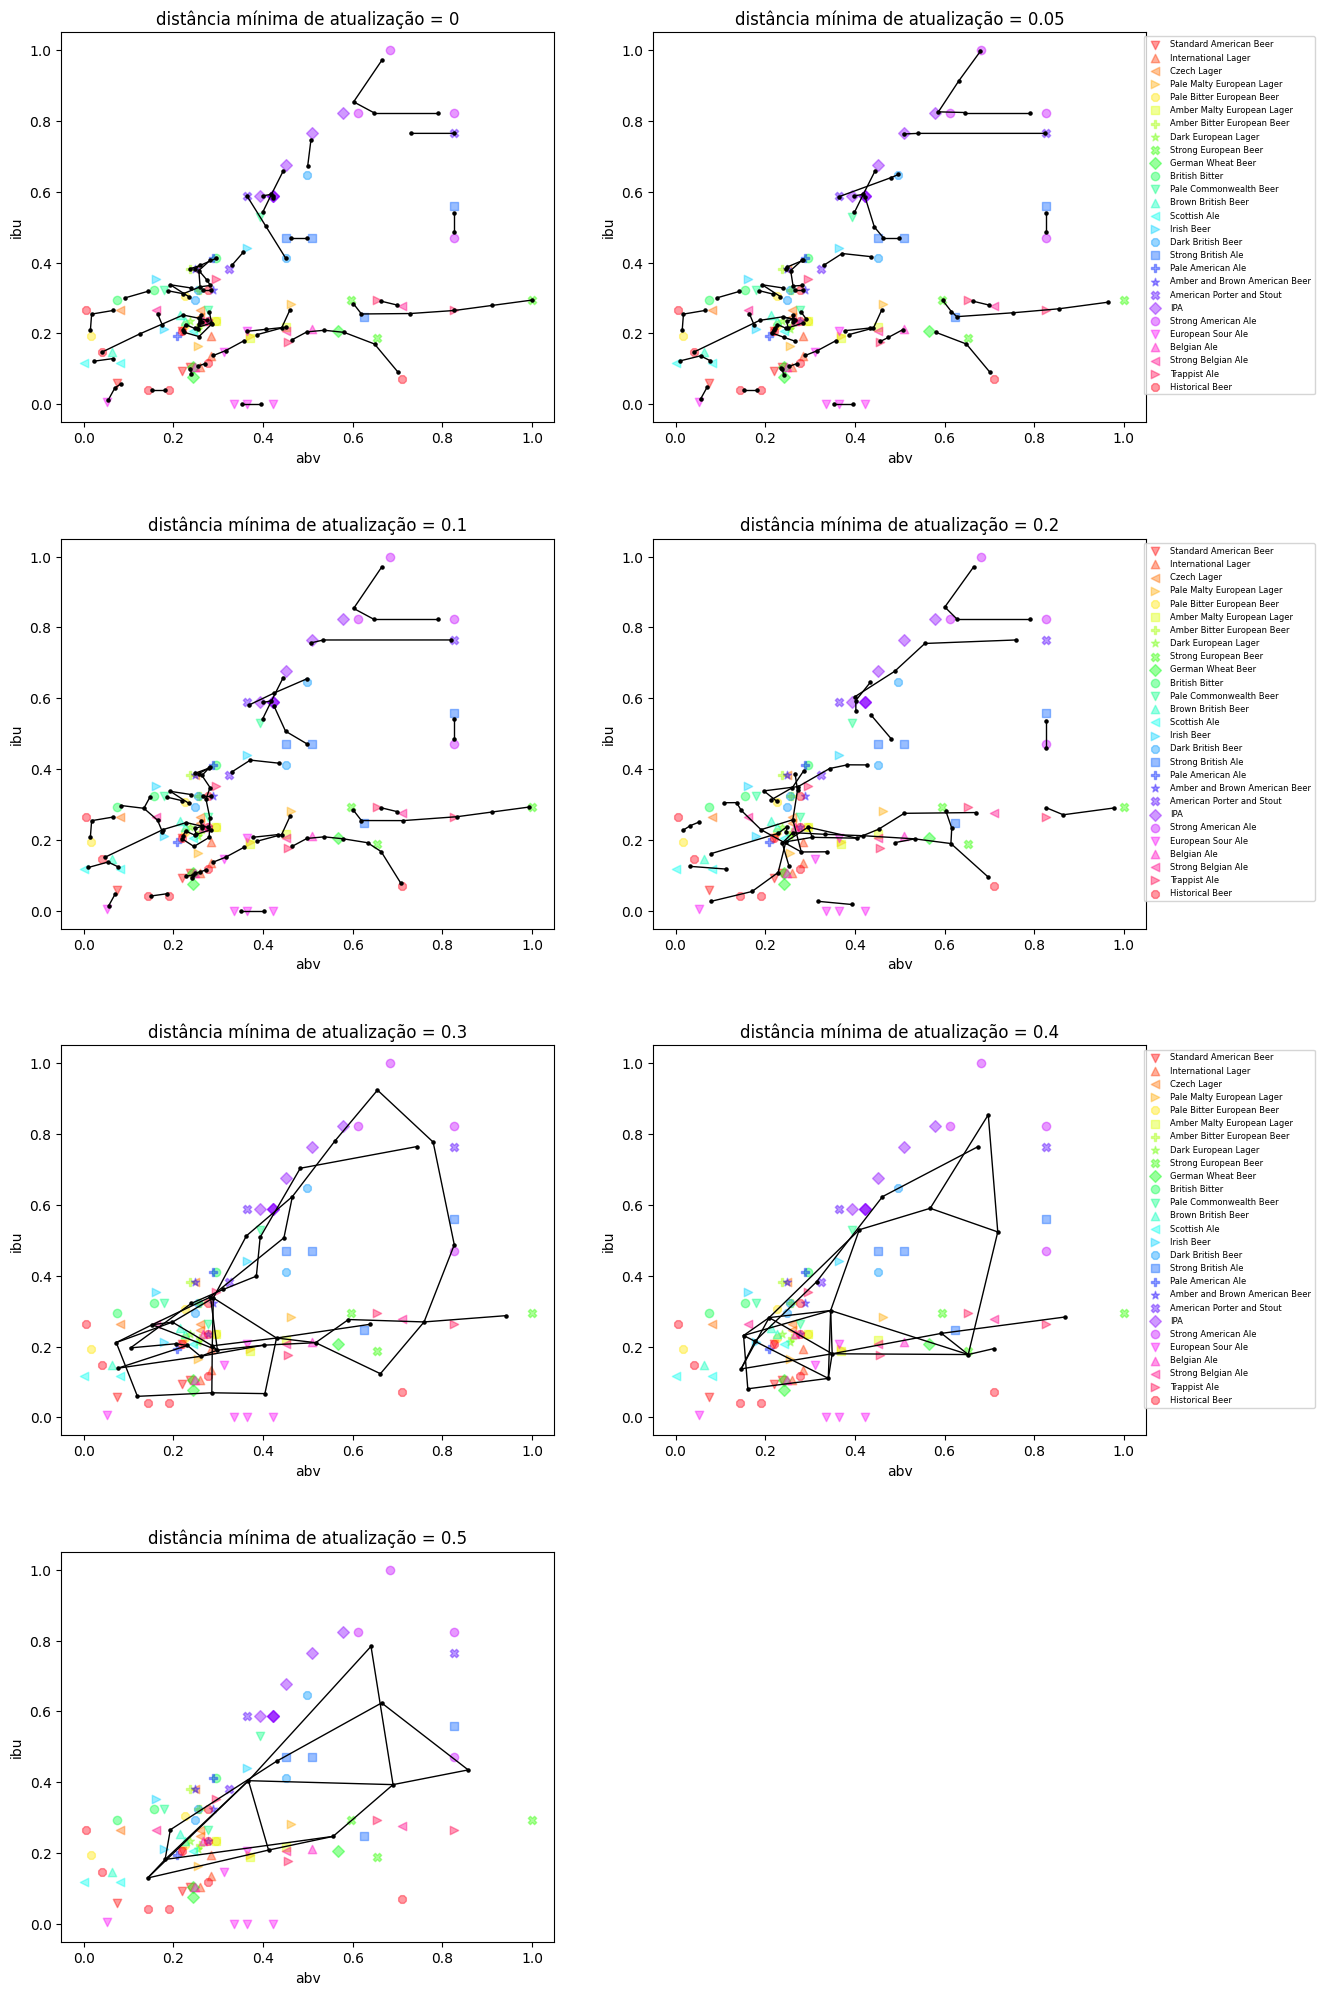

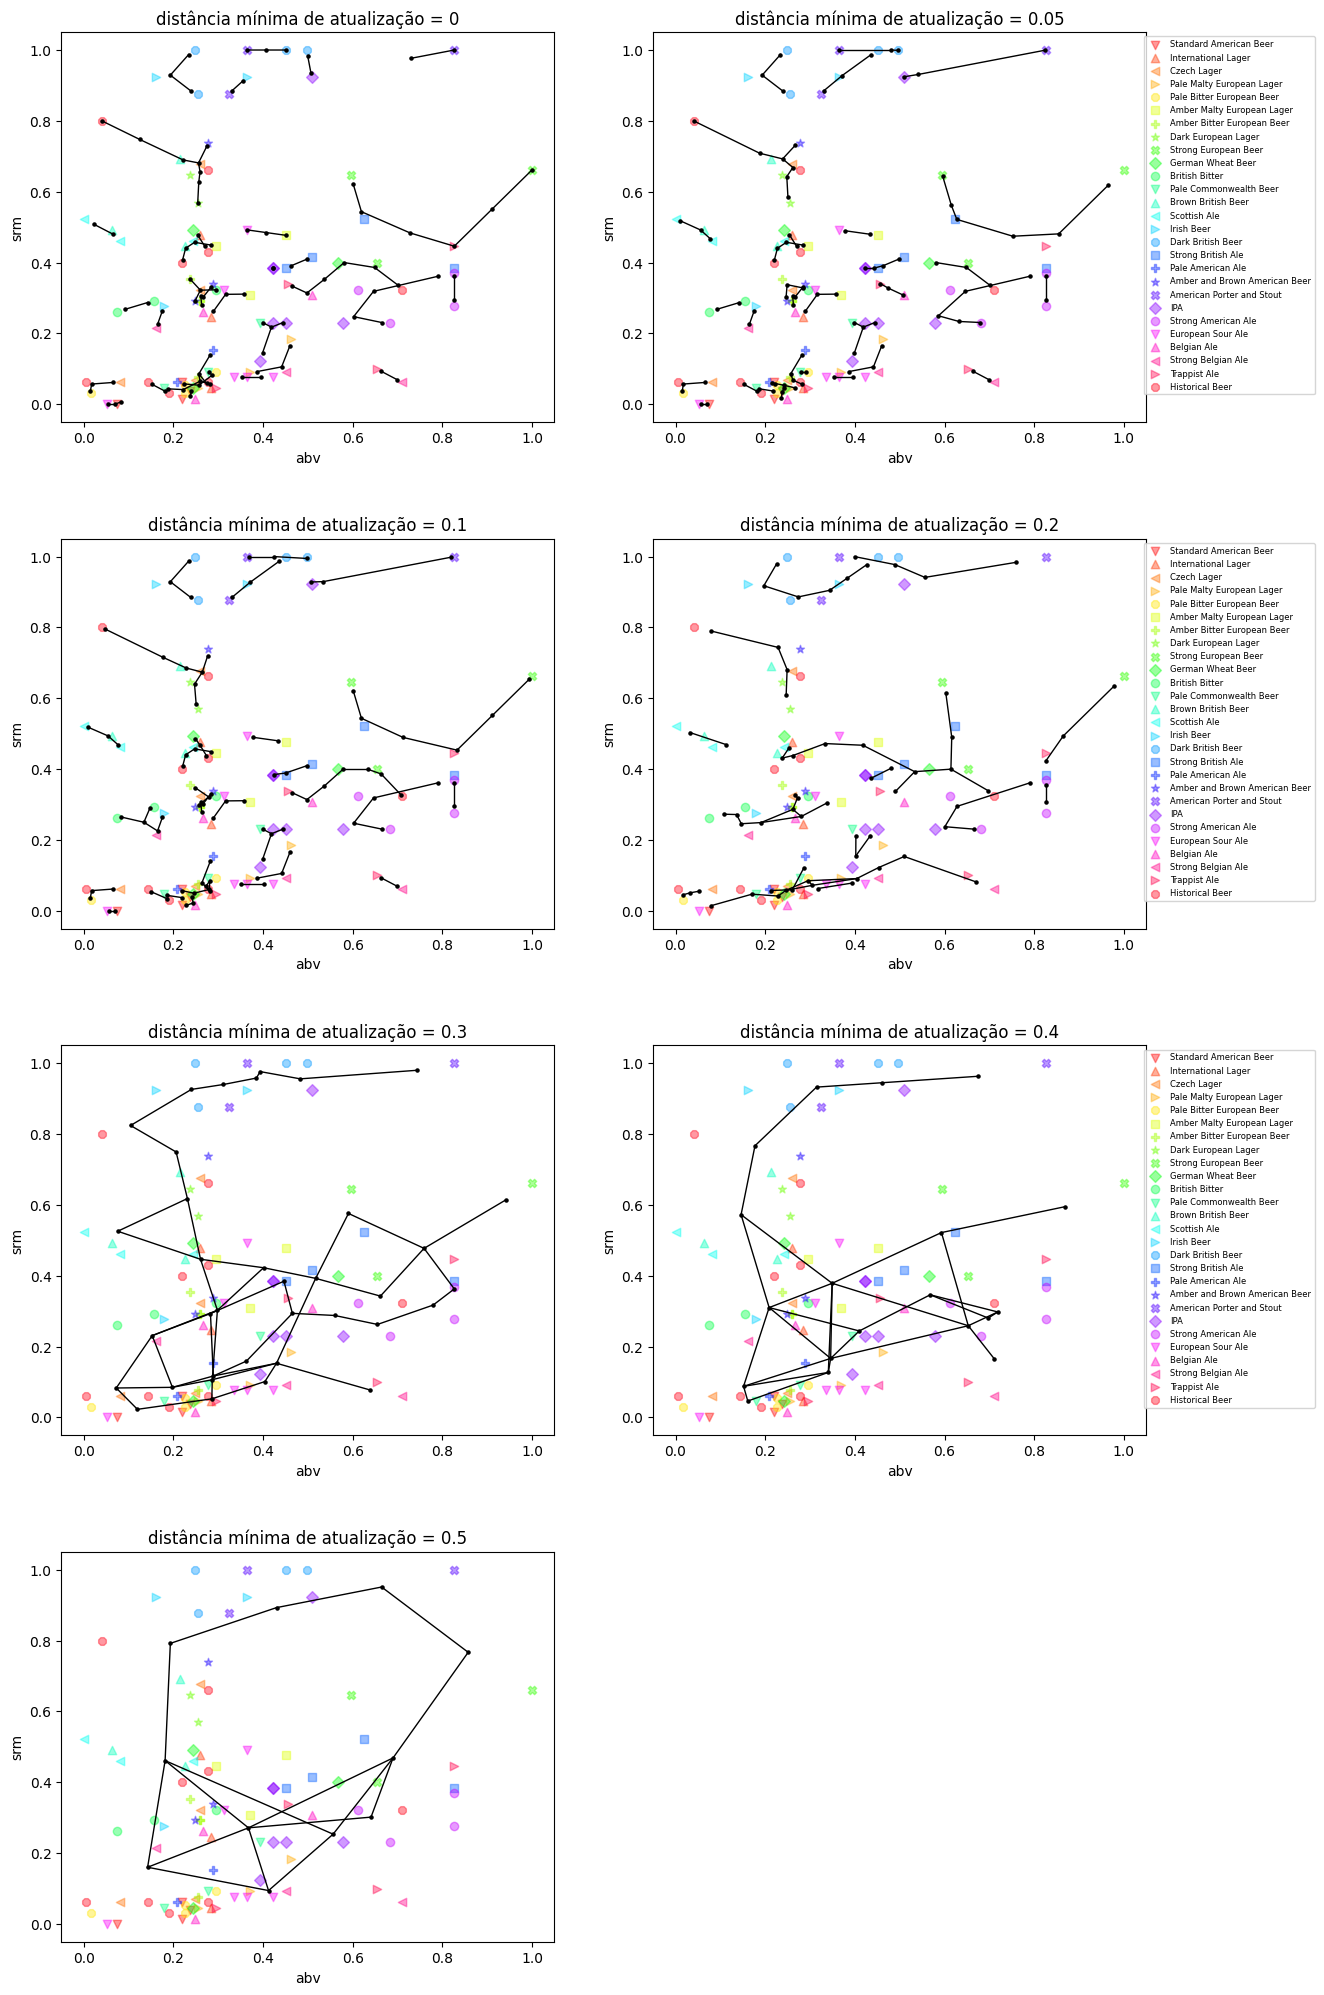

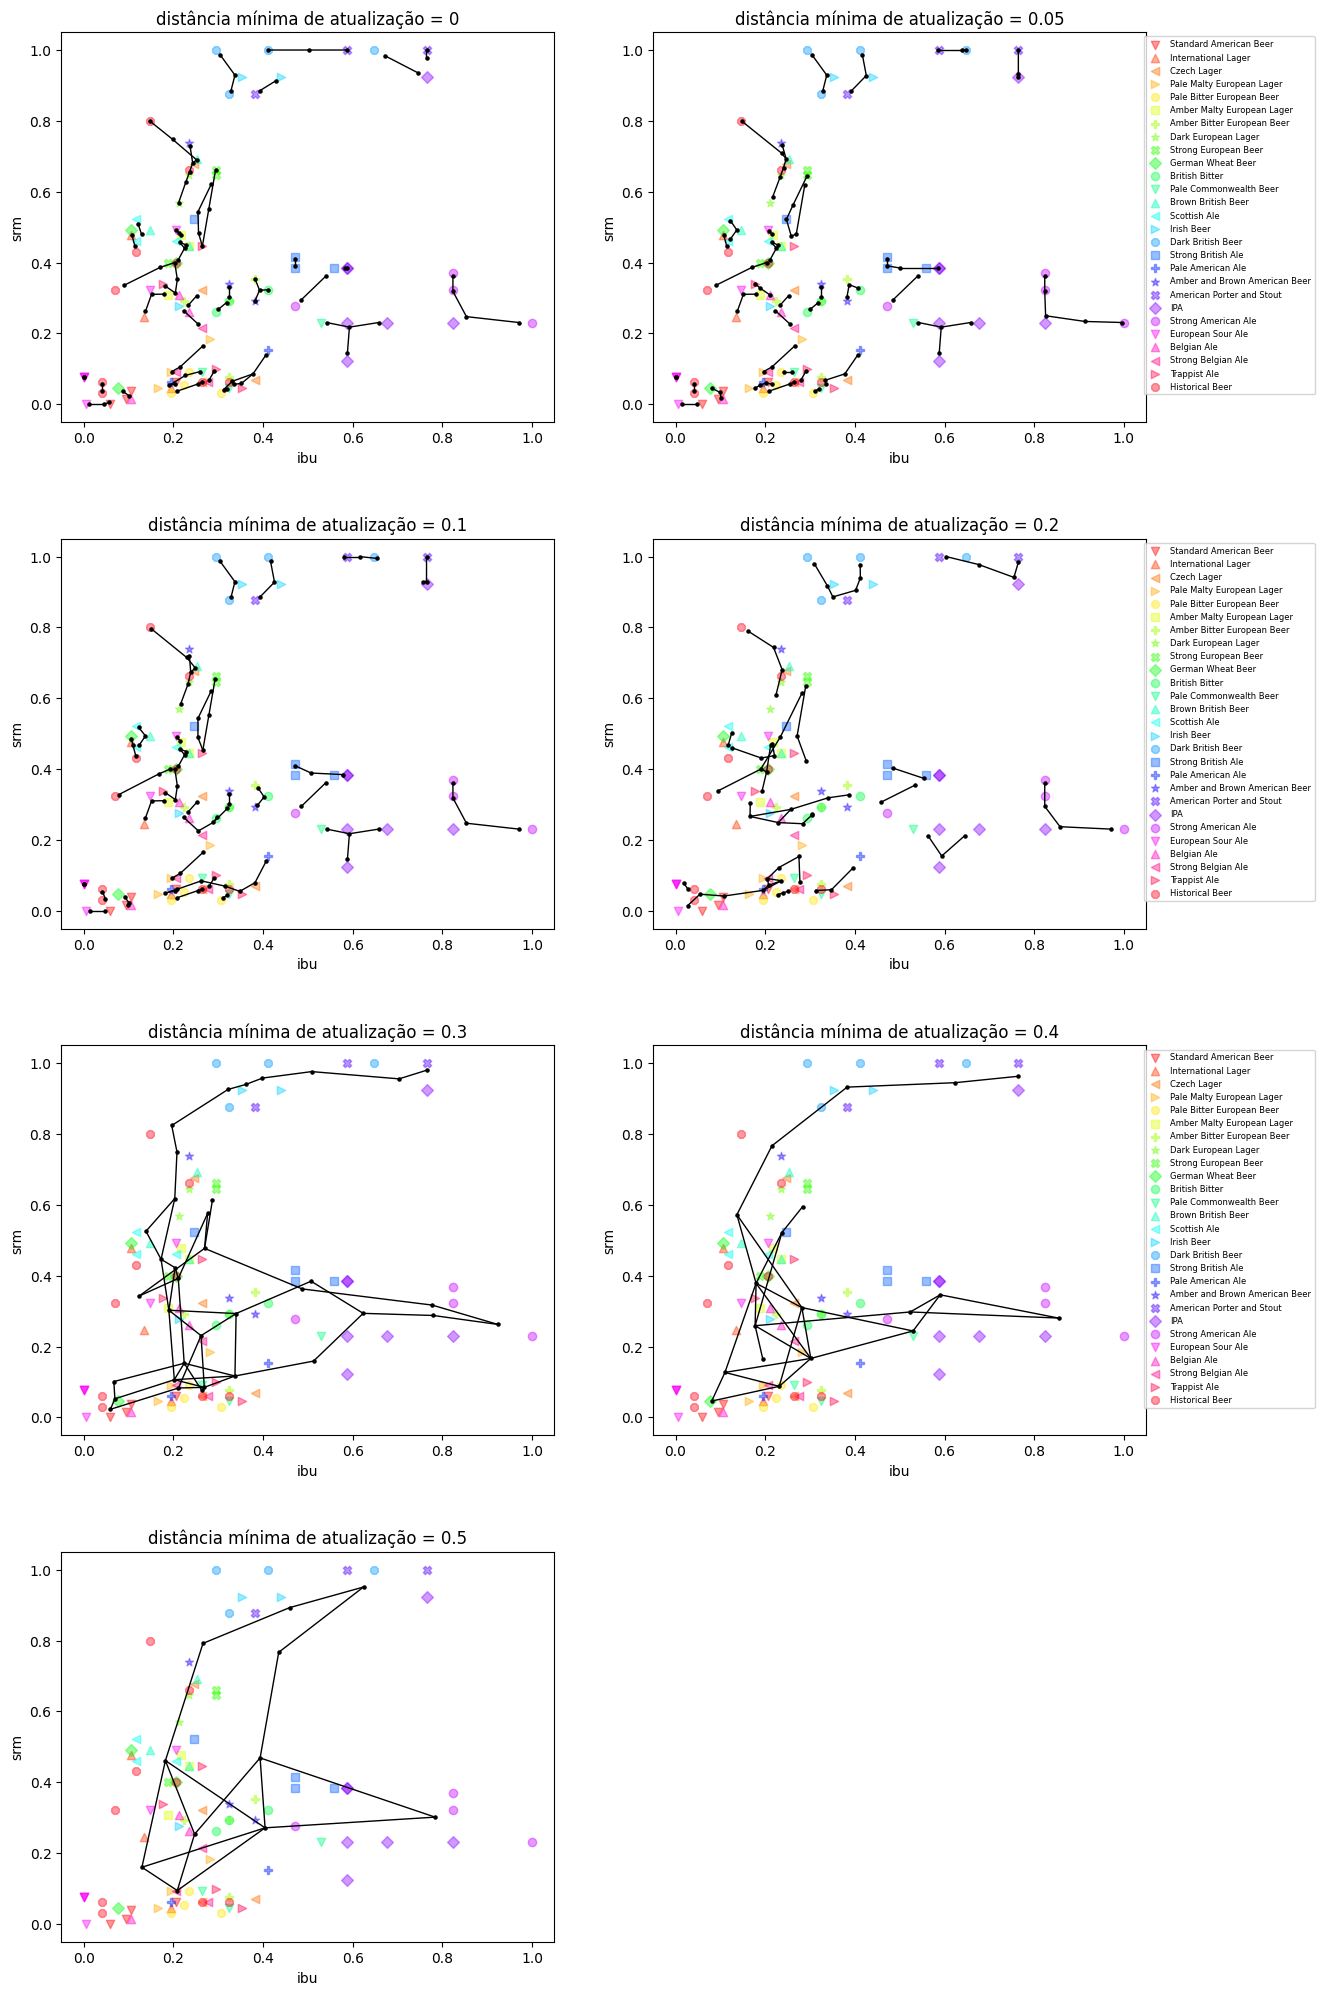

In [ ]:
test4_min_dist = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]  # padrão = 0

epochs=1000
gng_models = [
    algorithms.GrowingNeuralGas(
        n_inputs = len(feature_names),
        n_start_nodes = 2, 
        max_nodes = new_max_num_super_styles,
        min_distance_for_update = min_dist
    ) for min_dist in test4_min_dist
]

i=0
for gng_model in gng_models:
  gng_model.train(styles_mean[feature_names], epochs = epochs)
  print("{} nós e {} arestas geradas usando {} como distância mínima de atualização de neurônios".format(gng_model.graph.n_nodes, gng_model.graph.n_edges, test4_min_dist[i]))
  i = i + 1

show_all_gng_models(gng_models,"distância mínima de atualização = {value}", test4_min_dist)
